In [1]:
import time
import datetime
import gc
from random import random
from random import shuffle

from collections import Counter
from itertools import combinations
import tqdm

from multimodalrec.multimodalrec import MultimodalRec
# from multimodalrec.model import model

#from multimodalrec.model import SiameseLSTM
from data import data_creation as dc

import numpy as np
import pandas as pd
import tensorflow as tf
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [6]:
recmodel = MultimodalRec()
recmodel.get_trailer_features(load=True, dataset=10,trailer_directory='/Volumes/TOSHIBA EXT/sampled_images/', 
                              sequence_dir='/Users/salihgundogdu/Desktop/gits/multimodalrec/data10/visual_features/', 
                              audio_directory='/Users/salihgundogdu/Desktop/gits/multimodalrec/data10/audio_features', year_start=1900)

  1%|          | 61/8278 [00:00<00:13, 605.15it/s]

(7406120, 4)
Visual Representations are extracting...


  1%|▏         | 121/8275 [00:00<00:06, 1188.31it/s]

Done.
Audio Representations are extracting...


100%|██████████| 8275/8275 [00:07<00:00, 1072.47it/s]


Done.


In [7]:
ratings_df_training_filtered, ratings_df_val_filtered, ratings_df_test_filtered = recmodel.preprocess_dataset_in_matrix(rand_state=123)
print(ratings_df_training_filtered.shape, ratings_df_val_filtered.shape, ratings_df_test_filtered.shape)

  2%|▏         | 126/6347 [00:00<00:04, 1256.87it/s]

Training Sample: 6347
Validation Sample: 250
Test Sample: 515


100%|██████████| 515/515 [00:02<00:00, 181.23it/s]


Training User-Movie Latent Factors are extracting...
(5010778, 4) 6896 62455
(2147477, 4) 6784 62252
The sparsity level of training dataset is 98.8%


  0%|          | 0/62455 [00:00<?, ?it/s]

Done.


100%|██████████| 62455/62455 [01:17<00:00, 806.64it/s]


User dataframe shape: (62455, 100)


  1%|          | 48/6337 [00:00<00:13, 478.05it/s]

Trailer dictinaries are being created



100%|██████████| 515/515 [00:04<00:00, 115.50it/s]

(1919361, 4) (823786, 4) (40777, 4)


In [8]:
train = ratings_df_training_filtered[ratings_df_training_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
val   = ratings_df_val_filtered[ratings_df_val_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
test  = ratings_df_test_filtered[ratings_df_test_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
train = train[train.Movie.isin(list(recmodel.df_audio.keys()))].copy()
val   = val[val.Movie.isin(list(recmodel.df_audio.keys()))].copy()
test  = test[test.Movie.isin(list(recmodel.df_audio_test.keys()))].copy()

print(val.shape)
val   = val[val.Movie.isin(list(train.Movie.tolist()))].copy()
val   = val[val.User.isin(list(train.User.tolist()))].copy()
val.shape

(762949, 4)


(762412, 4)

**Number of movies we have to sort by prediction score computed by our framework and CF model**

In [9]:
new_movies = val.Movie.unique().tolist()#[:2]
users = val.User.unique().tolist()#[:10]
print(len(new_movies))

5928


## Create RecSys Test Set New-Movies vs All User


In [12]:
train.shape

(1776446, 4)

In [13]:
new_movies = val.Movie.unique().tolist()#[:2]
users = val.User.unique().tolist()#[:10]
print(len(new_movies)*len(users))

random.shuffle(new_movies)
random.shuffle(users)
new_movies = new_movies
users = users[:1000] # use 1000 users out of ~60,000 users to make prediction data smaller (testing purposes)

print(len(new_movies)*len(users))

350730120
5928000


In [14]:
import itertools
tuples = list(itertools.product(users, new_movies))
len(tuples)

5928000

In [15]:
synt_test = pd.DataFrame(tuples)
synt_test.columns = ['User', 'Movie']
synt_test['Rating'] = synt_test.shape[0]*[6.]
synt_test.shape

(5928000, 3)

In [16]:
synt_test_gt, synt_test_pr, synt_test_acc, synt_test_loss = recmodel.make_prediction_in_matrix(test=synt_test, data_source="A+I", 
                                                                 concat_type='Multiplicative', 
                                                                 conv_type='Both', batch_size = 128, seq_len = 60, max_iter=4000, learning_rate = 0.00008, epochs = 1, n_channels_user = 100, n_classes = 1, n_channels_audio = 100, n_channels_image = 2048, 
                                                                 save_dir = "./model/rating/")

Initialize new model
Creating loss... 

Loading parameters for the RatingModel
INFO:tensorflow:Restoring parameters from checkpoints/RatingModel-1900


In [17]:
len(synt_test_pr[0]) # number of predictions

5928000

In [18]:
synt_test['Score'] = [e[0] for e in list(synt_test_pr[0])] 
synt_test.shape

(5928000, 4)

In [19]:
synt_test.tail()

,User,Movie,Rating,Score
5927995,51001,4326,6.0,0.469424
5927996,51001,1973,6.0,0.321349
5927997,51001,513,6.0,0.370396
5927998,51001,3288,6.0,0.740968
5927999,51001,31032,6.0,0.870609


In [20]:
val.tail()

,User,Movie,Rating,Timestamp
7509226,21132,111,5.0,1996-10-30 09:28:20
7509231,19535,1343,5.0,2000-11-20 17:34:20
7509255,57926,1296,5.0,1997-06-10 17:14:37
7509257,64520,595,5.0,1996-07-25 07:00:55
7509258,57664,353,2.0,2002-03-21 14:47:47


## Train CF Model

In [89]:
from multimodalrec.viewership import CollaborativeFiltering, _svd_compute

cf_train = train#.sample(frac=0.8)
# cf_test = pd.merge(val, synt_test,how='left',left_on=['User','Movie'], right_on = ['User','Movie'])#.loc[~train.index.isin(cf_train.index)]

user_item_network_training = CollaborativeFiltering(cf_train)

(U, sigma, Vt) = _svd_compute(user_item_network_training.Ratings_demeaned, k=100)
sigma = np.diag(sigma)

print(U.shape)
print(Vt.T.shape)
print(sigma.shape)

user_ratings_mean = np.mean(user_item_network_training.R, axis = 1)
user_ratings_mean.reshape(-1, 1).shape

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

preds = pd.DataFrame(all_user_predicted_ratings, columns = user_item_network_training.Ratings.columns, index = user_item_network_training.Ratings.index)
preds.head()

movies = recmodel.data['Titles']
ratings = recmodel.data['training']

The sparsity level of training dataset is 99.5%
(61696, 100)
(6219, 100)
(100, 100)


In [21]:
print(val.shape)
cb_test = pd.merge(val, synt_test,how='left',left_on=['User','Movie'], right_on = ['User','Movie'])
# cb_test = cb_test.drop('Rating_y',axis=1)
# cb_test['gt'] = np.where(cb_test['Rating'] > 3, 1, 0)
# cb_test['rating_norm'] = cb_test.Rating_x/5.
cb_test.shape

(762412, 4)


(762412, 6)

In [22]:
synt_test.shape

(5928000, 4)

In [23]:
cb_test = cb_test[cb_test.Rating_y==6.]
cb_test.head(1)

,User,Movie,Rating_x,Timestamp,Rating_y,Score
26,3030,39,2.0,1999-12-25 09:14:23,6.0,0.731565


In [24]:
cb_train = pd.concat([train,val],axis=0)
# cb_train['gt'] = val_batch_gt.ravel()
# cb_train['score'] = val_batch_score.ravel()
cb_train['rating_norm'] = cb_train.Rating/5.
cb_train.head(1)

,User,Movie,Rating,Timestamp,rating_norm
457727,58642,4499,5.0,2001-07-08 03:30:09,1.0


In [99]:
def recommend_movies_cb(predictions, userID):
    try:
        top_nrecs = predictions[predictions.User==userID].Movie.tolist()
    except:
        return []
    return top_nrecs

def precision(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted)
    result = len(act_set & pred_set) / float(len(actual))
    return result

def recommend_movies_cf(predictions, userID, num_recommendations):
    try:
        top_nrecs = predictions[predictions.index==userID].iloc[0].sort_values(ascending=False).index.tolist()[:num_recommendations]#predictions.iloc[userID-1].sort_values(ascending=False).index.tolist()[:num_recommendations]
    except:
        return []
    return top_nrecs

In [43]:
act_set = set(movies_already_rated)
pred_set = set(movies_recommended)
result = len(act_set & pred_set) #/ float(len(actual))

In [59]:
len(movies_recommended)

2000

In [68]:
synt_test[synt_test.User==usr].Movie.nunique()
val.Movie.nunique()

5928

In [69]:
val.shape

(762412, 4)

In [71]:
len(all_movs)

5928

In [60]:
all_movs = synt_test.Movie.unique().tolist()

## Precision@k

In [70]:
all_movs = synt_test.Movie.unique().tolist()

val_filtered = val[val.Movie.isin(all_movs)].copy()
val_filtered.shape

(762412, 4)

In [105]:
print(movies_already_rated)
set(recommend_movies_cf(preds, usr, len(all_movs))) & set(movies_already_rated)

[25]


{25}

In [132]:
train.Movie.tolist()
train.User.tolist()

,User,Movie,Rating,Score


In [157]:
synt_test.shape

(5928000, 4)

In [150]:
train.shape

(1776446, 4)

In [154]:
synt_test_filtered = synt_test.copy()
synt_test_filtered['tuple'] = list(zip(synt_test.User.tolist(),synt_test.Movie.tolist()))
synt_test_filtered.head()

train_filtered = train.copy()
train_filtered['tuple'] = list(zip(train.User.tolist(),train.Movie.tolist()))
train_filtered.head()

,User,Movie,Rating,Timestamp,tuple
457727,58642,4499,5.0,2001-07-08 03:30:09,"(58642, 4499)"
4062976,47055,2762,2.0,2000-12-08 13:27:18,"(47055, 2762)"
4313932,29795,110,5.0,1996-05-30 08:38:25,"(29795, 110)"
5468339,13418,2716,4.5,2003-07-20 15:06:25,"(13418, 2716)"
3031174,57380,370,1.5,2006-08-21 15:38:05,"(57380, 370)"


In [155]:
synt_test_filtered = synt_test_filtered[~synt_test_filtered.tuple.isin(train_filtered.tuple)]
synt_test_filtered.head()

,User,Movie,Rating,Score,tuple
0,70002,2435,6.0,0.426176,"(70002, 2435)"
1,70002,27391,6.0,0.704123,"(70002, 27391)"
2,70002,27317,6.0,0.652552,"(70002, 27317)"
3,70002,922,6.0,0.896468,"(70002, 922)"
4,70002,6144,6.0,0.632742,"(70002, 6144)"


In [173]:
len(list(set(all_movs) & set(preds.columns.tolist())))

5928

In [175]:
len(all_movs)

5928

In [177]:
preds_filtered = preds[all_movs].copy()
preds_filtered.shape

(61696, 5928)

In [158]:
preds.shape

(61696, 6219)

In [190]:
precisionK, bestK, randomK = [],[],[]
precisionK_cf = []
for k_ in list(np.arange(10,5000,50))+[len(all_movs)]:
    print(k_)
    err=0
    prec_all= []
    prec_all_cf = []
    enum=0
    best_case = []
    random_case = []
    num_of_rated_movies = 0


    for usr in cb_test.User.unique().tolist():
        user_df = synt_test[synt_test.User==usr].sort_values('Score',ascending=False).head(k_)
        movies_recommended = user_df.Movie.tolist()
        movies_recommended_df = recommend_movies_cf(preds_filtered, usr, k_) 
        movies_already_rated = val[(val.User==usr)&(val.Rating>3.5)].Movie.tolist()
        if len(movies_already_rated)!=0:
            prec_all.append(precision(movies_already_rated, movies_recommended, k_))
            prec_all_cf.append(precision(movies_already_rated, movies_recommended_df, k_))
            best_case.append(precision(movies_already_rated, movies_already_rated, k_))
            random.shuffle(all_movs)
            random_case.append(precision(movies_already_rated, all_movs[:k_], k_)) 
            enum+=1
        else:
            err+=1
    
    precisionK.append(np.mean(prec_all))
    precisionK_cf.append(np.mean(prec_all_cf))
    bestK.append(np.mean(best_case))
    randomK.append(np.mean(random_case))

10
60
110
160
210
260
310
360
410
460
510
560
610
660
710
760
810
860
910
960
1010
1060
1110
1160
1210
1260
1310
1360
1410
1460
1510
1560
1610
1660
1710
1760
1810
1860
1910
1960
2010
2060
2110
2160
2210
2260
2310
2360
2410
2460
2510
2560
2610
2660
2710
2760
2810
2860
2910
2960
3010
3060
3110
3160
3210
3260
3310
3360
3410
3460
3510
3560
3610
3660
3710
3760
3810
3860
3910
3960
4010
4060
4110
4160
4210
4260
4310
4360
4410
4460
4510
4560
4610
4660
4710
4760
4810
4860
4910
4960
5928


In [180]:
# print(prec_all_cf)
# print(precisionK)

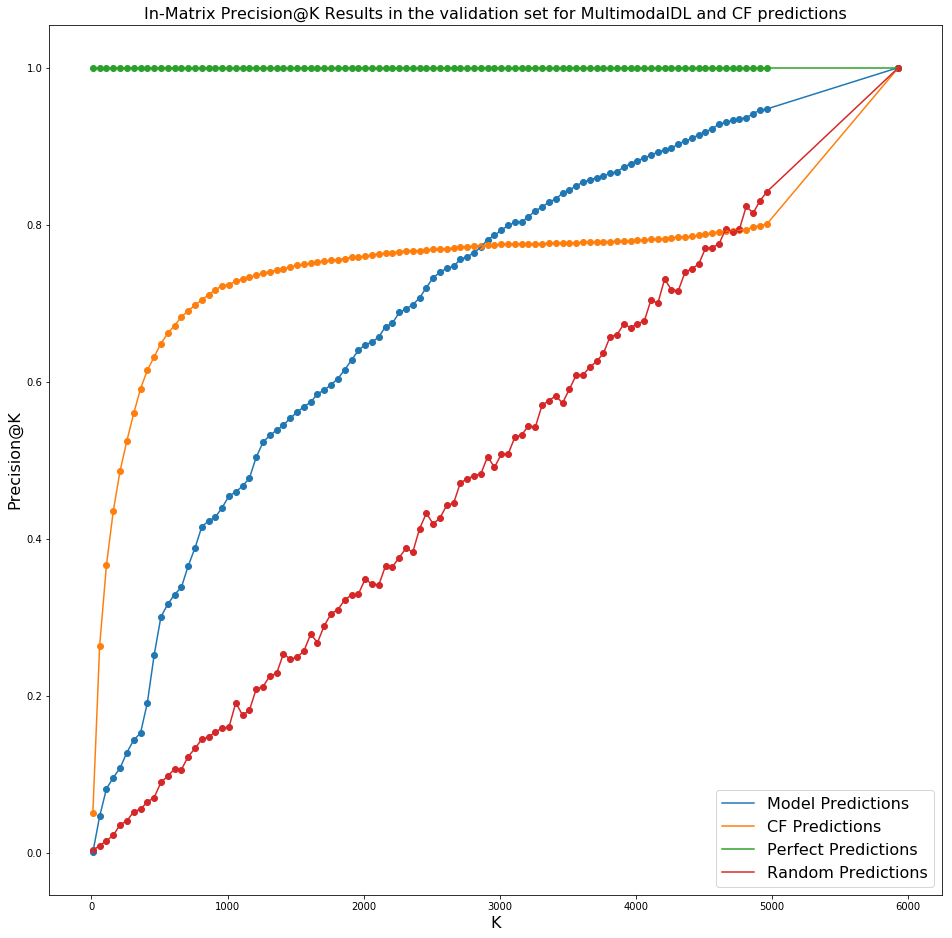

In [191]:
x = list(np.arange(10,5000,50))+[len(all_movs)]
fig, ax = plt.subplots(figsize=(16, 16))

ax.plot(x, precisionK)
ax.plot(x, precisionK_cf)
ax.plot(x, bestK)
ax.plot(x, randomK)
ax.scatter(x, precisionK)
ax.scatter(x, precisionK_cf)
ax.scatter(x, bestK)
ax.scatter(x, randomK)
plt.ylabel('Precision@K',fontsize=16)
plt.xlabel('K',fontsize=16)
plt.legend(['Model Predictions','CF Predictions','Perfect Predictions','Random Predictions'],fontsize=16)
# plt.ylim(0,0.6)
plt.title('In-Matrix Precision@K Results in the validation set for MultimodalDL and CF predictions',fontsize=16)
# plt.yscale('log')
plt.show()

# Rest is pretty messy... :)

In [80]:
prec_all

[1.0]

In [81]:
best_case

[1.0]

In [82]:
random_case

[1.0]

---

In [43]:
# cb_new_test

In [91]:
# precisionK, bestK, randomK = [],[],[]

# for k_ in [10,20,30,40,50,60,70,80,90,100,125,150,200,250,300,400,500,750,1000,2000,3000,len(all_movs)]:
#     print(k_)
#     cb_list = []
#     for usr in cb_test.User.unique().tolist():
#         user_df = cb_test[cb_test.User==usr].sort_values('Score',ascending=False).head(k_)
#         cb_list.append(user_df)
#         #break
#     cb_new_test = pd.concat(cb_list,axis=0)
#     cb_new_test.shape

#     tp_all=0
#     fp_all=0
#     err=0
#     prec_all=0
#     enum=0
#     best_case = 0
#     random_case = 0
#     num_of_rated_movies = 0
#     for usr in tqdm.tqdm(cb_new_test.User.unique().tolist(),position=0):
#         recommendations = recommend_movies(cb_new_test, usr)

#         movies_recommended = recommendations#.MovieID.tolist()
#         if movies_recommended != []: 

#             movies_already_rated = val[(val.User==usr)&(val.Rating>3.0)].Movie.tolist()
#             num_of_rated_movies += len(movies_already_rated)
#             tp = len(set(movies_already_rated) & set(movies_recommended)) 
#             fp = len(movies_already_rated) - len(set(movies_already_rated) & set(movies_recommended)) 

#             if len(movies_already_rated)!=0:
#                 prec_all+=precision(movies_already_rated, movies_recommended, k_) #* len(movies_already_rated)
#                 best_case+=precision(movies_already_rated, movies_already_rated, k_)  #* len(movies_already_rated)
#                 random.shuffle(all_movs)
#                 random_case+=precision(movies_already_rated, all_movs[:k_], k_)  #* len(movies_already_rated)
#                 enum+=1 #len(movies_already_rated)
#             tp_all+=tp
#             fp_all+=fp
#         else:
#             err+=1
            

#     precisionK.append(prec_all/enum)
#     bestK.append(best_case/enum)
#     randomK.append(random_case/enum)
#     #break

In [87]:
print(precisionK, bestK, randomK)

[0.0006555934669190529, 0.024681136830779934, 0.025500824268596595, 0.025500824268596595, 0.03654814419201508, 0.04657628517861942, 0.06399367217253114, 0.06461328873268674, 0.08031596220897036, 0.08114768780090167, 0.08481412394154891, 0.09540441119992843, 0.10303368157758727, 0.1265988651040116, 0.1404326176237127] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.0017792711611389314, 0.00329463176647697, 0.005247586982476736, 0.004962878296870844, 0.008793806448928682, 0.01131458423507131, 0.00951204142058683, 0.018244865069967347, 0.01094518649778775, 0.018299375677168144, 0.019725903775906127, 0.023473120086339568, 0.03712137218951242, 0.04237833086163483, 0.047122543445739504]


In [80]:
preds_filtered[preds_filtered.index==9].iloc[0].sort_values(ascending=False).index.tolist()[:10]

[2502, 1220, 4878, 4034, 3897, 1732, 1374, 1517, 8784, 1204]

In [74]:
preds_filtered.head(3)

Movie,1,7,12,23,24,28,30,32,35,38,...,48142,48385,48412,48516,48774,48780,48783,49132,49272,49824
User,,,,,,,,,,,,,,,,,,,,,
9,0.086000,0.050090,0.019245,-0.012407,0.005773,0.056921,-0.008009,0.262521,-0.004397,0.006209,...,0.007172,0.052292,-0.003003,0.080142,-0.001758,0.032115,-0.006636,-0.003472,0.044426,-0.000849
12,-0.005182,-0.024125,-0.005968,0.000712,0.009743,-0.043181,-0.005124,-0.001881,-0.011747,-0.001553,...,-0.003864,-0.002371,-0.001719,-0.004917,-0.003012,-0.005997,-0.001265,-0.001291,-0.004076,-0.002978
17,-0.060117,-0.016893,-0.007936,0.008146,0.003814,-0.010234,0.023900,-0.074296,0.018762,0.003071,...,-0.000810,0.005694,0.000979,0.004636,-0.001695,0.000547,0.002281,0.001312,0.004898,-0.001295


In [93]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    try:
        top_nrecs = predictions[predictions.index==userID].iloc[0].sort_values(ascending=False).index.tolist()[:num_recommendations]#predictions.iloc[userID-1].sort_values(ascending=False).index.tolist()[:num_recommendations]
    except:
        return []
    return top_nrecs

In [27]:
cf_test =pd.merge(val, synt_test,how='left',left_on=['User','Movie'], right_on = ['User','Movie'])
cf_test = cf_test[cf_test.Rating_y==6.]
cf_test.head(1)

,User,Movie,Rating_x,Timestamp,Rating_y,Score
20,61409,4123,2.5,2004-02-27 19:52:22,6.0,0.668748


In [29]:
train.shape

(1777476, 4)

In [30]:
val.shape

(761500, 4)

In [32]:
cb_test.head(2)

,User,Movie,Rating_x,Timestamp,Rating_y,Score
20,61409,4123,2.5,2004-02-27 19:52:22,6.0,0.668748
34,35049,532,5.0,1996-06-03 11:52:03,6.0,0.364370


In [33]:
val[(val.User==61409)&(val.Movie==4123)]

,User,Movie,Rating,Timestamp
198,61409,4123,2.5,2004-02-27 19:52:22


In [34]:
from multimodalrec.viewership import CollaborativeFiltering, _svd_compute

cf_train = train#.sample(frac=0.8)
# cf_test = pd.merge(val, synt_test,how='left',left_on=['User','Movie'], right_on = ['User','Movie'])#.loc[~train.index.isin(cf_train.index)]

user_item_network_training = CollaborativeFiltering(cf_train)

(U, sigma, Vt) = _svd_compute(user_item_network_training.Ratings_demeaned, k=100)
sigma = np.diag(sigma)

print(U.shape)
print(Vt.T.shape)
print(sigma.shape)

user_ratings_mean = np.mean(user_item_network_training.R, axis = 1)
user_ratings_mean.reshape(-1, 1).shape

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

preds = pd.DataFrame(all_user_predicted_ratings, columns = user_item_network_training.Ratings.columns, index = user_item_network_training.Ratings.index)
preds.head()

movies = recmodel.data['Titles']
ratings = recmodel.data['training']

The sparsity level of training dataset is 99.5%
(61752, 100)
(6211, 100)
(100, 100)


In [35]:
preds.head(2)

Movie,1,2,6,7,10,11,12,13,14,16,...,49314,49347,49526,49530,49642,49644,49649,49651,49824,50064
User,,,,,,,,,,,,,,,,,,,,,
1,-0.068199,0.776175,-0.218973,-0.087219,0.961627,-0.083902,0.037291,0.057548,0.004584,0.084160,...,-0.003083,-0.000637,-0.003194,0.000507,-0.004292,-0.003357,-0.003155,-0.004441,0.000003,-0.002881
2,0.011931,-0.001849,0.040095,0.020500,0.046630,-0.052233,0.007608,-0.007725,0.037663,-0.059759,...,0.000141,0.000047,0.000394,-0.000524,0.000046,0.000746,0.000184,-0.001273,0.000856,0.000392


In [36]:
all_movs = train.Movie.unique().tolist()
len(all_movs)

6211

In [48]:
all_users = train.User.unique().tolist()
len(all_users)

61752

In [49]:
cb_test.Movie.nunique()

1840

In [38]:
cf_new_test.head(2)

NameError: name 'cf_new_test' is not defined

In [3]:
cf_test.columns

NameError: name 'cf_test' is not defined

In [39]:
preds_filtered = preds[preds.index.isin(cf_test.User.tolist())].copy()
# preds_filtered = preds_filtered[cf_test.Movie.tolist()]
preds_filtered.shape

(16903, 6211)

In [73]:
print(cf_train.Movie.nunique())
print(cb_train.Movie.nunique())

6211
6211


In [46]:
preds_filtered = preds_filtered.T[preds_filtered.T.index.isin(cf_test.Movie.tolist())]
preds_filtered = preds_filtered.T
preds_filtered.shape

(16903, 1840)

In [64]:
cf_new_test.head()

,User,Movie,Rating_x,Timestamp,Rating_y,Score
101747,61409,2493,5.0,2000-01-23 09:11:50,6.0,0.706713
20,61409,4123,2.5,2004-02-27 19:52:22,6.0,0.668748
163272,61409,1500,4.5,2003-10-10 19:25:42,6.0,0.449380
610827,61409,4447,4.5,2003-10-10 19:18:46,6.0,0.377998
638849,35049,1,5.0,1996-06-03 11:35:11,6.0,0.837924


In [94]:
precisionK, bestK, randomK = [],[],[]

for k_ in [10,20,30,40,50,60,70,80,90,100,125,150,200,250,300]:
    print(k_)
    cb_list = []
    for usr in cf_test.User.unique().tolist():
        user_df = cf_test[cf_test.User==usr].sort_values('Score',ascending=False).head(k_)
        cb_list.append(user_df)
        #break
    cf_new_test = pd.concat(cb_list,axis=0)
    cf_new_test.shape

    tp_all=0
    fp_all=0
    err=0
    prec_all=0
    enum=0
    best_case = 0
    random_case = 0
    num_of_rated_movies = 0
    for usr in tqdm.tqdm(cf_new_test[cf_new_test.User.isin(cf_train.User.unique().tolist())].User.unique().tolist(),position=0):
        recommendations = recommend_movies(preds_filtered, usr, movies, ratings, k_)

        movies_recommended = recommendations#.MovieID.tolist()
        if movies_recommended != []: 

            movies_already_rated = cf_new_test[(cf_new_test.User==usr)&(cf_new_test.Rating_x>3.0)].Movie.tolist()

            tp = len(set(movies_already_rated) & set(movies_recommended)) #len(movies_already_rated) - len(set(movies_already_rated)- set(movies_recommended))
            fp = len(movies_already_rated) - len(set(movies_already_rated) & set(movies_recommended)) #len(set(movies_already_rated)- set(movies_recommended))

            if len(movies_already_rated)!=0:
                prec_all+=precision(movies_already_rated, movies_recommended, k_) #* len(movies_already_rated)
                best_case+=precision(movies_already_rated, movies_already_rated, k_)  #* len(movies_already_rated)
                random.shuffle(all_movs)
                random_case+=precision(movies_already_rated, all_movs[:k_], k_)  #* len(movies_already_rated)
                enum+=1 #len(movies_already_rated)
            tp_all+=tp
            fp_all+=fp
        else:
            err+=1


    precisionK.append(prec_all/enum)
    bestK.append(best_case/enum)
    randomK.append(random_case/enum)
    #break


10


100%|██████████| 16903/16903 [01:01<00:00, 277.09it/s]


20


100%|██████████| 16903/16903 [01:00<00:00, 280.54it/s]


30


100%|██████████| 16903/16903 [01:00<00:00, 280.29it/s]


40


100%|██████████| 16903/16903 [01:00<00:00, 279.04it/s]


50


100%|██████████| 16903/16903 [01:00<00:00, 278.20it/s]


60


100%|██████████| 16903/16903 [01:00<00:00, 278.10it/s]


70


100%|██████████| 16903/16903 [01:00<00:00, 279.31it/s]


80


100%|██████████| 16903/16903 [01:00<00:00, 278.88it/s]


90


100%|██████████| 16903/16903 [01:00<00:00, 277.70it/s]


100


100%|██████████| 16903/16903 [01:00<00:00, 277.92it/s]


125


100%|██████████| 16903/16903 [01:00<00:00, 277.93it/s]


150


100%|██████████| 16903/16903 [01:00<00:00, 277.96it/s]


200


100%|██████████| 16903/16903 [01:01<00:00, 275.21it/s]


250


100%|██████████| 16903/16903 [01:01<00:00, 276.65it/s]


300


100%|██████████| 16903/16903 [01:01<00:00, 300.52it/s]


In [115]:
# Evaluate Together

precisionK, precisionK_cb, bestK, randomK = [],[],[], []

for k_ in [10,20,30,40,50,60,70,80,90,100,125,150,200,250,300]:
    print(k_)
    cb_list = []
    for usr in cf_test.User.unique().tolist():
        user_df = cf_test[cf_test.User==usr].sort_values('Score',ascending=False).head(k_)
        cb_list.append(user_df)
        #break
    cf_new_test = pd.concat(cb_list,axis=0)
    cf_new_test.shape
    
    cb_list = []
    for usr in cb_test.User.unique().tolist():
        user_df = synt_test[synt_test.User==usr].sort_values('Score',ascending=False).head(k_)
        cb_list.append(user_df)
        #break
    cb_new_test = pd.concat(cb_list,axis=0)
    cb_new_test.shape

    tp_all=0
    fp_all=0
    err=0
    prec_all=0
    prec_all_cb=0
    enum=0
    best_case = 0
    random_case = 0
    num_of_rated_movies = 0
    for usr in tqdm.tqdm(cf_new_test[cf_new_test.User.isin(cf_train.User.unique().tolist())].User.unique().tolist(),position=0):
        
        recommendations = recommend_movies(preds_filtered, usr, movies, ratings, k_)
        movies_recommended = recommendations
        
        recommendations_cb = recommend_movies_cb(cb_new_test, usr)
        movies_recommended_cb = recommendations_cb
        
        if movies_recommended != [] and movies_recommended_cb != []: 

            movies_already_rated = cf_new_test[(cf_new_test.User==usr)&(cf_new_test.Rating_x>3.0)].Movie.tolist()

            tp = len(set(movies_already_rated) & set(movies_recommended)) #len(movies_already_rated) - len(set(movies_already_rated)- set(movies_recommended))
            fp = len(movies_already_rated) - len(set(movies_already_rated) & set(movies_recommended)) #len(set(movies_already_rated)- set(movies_recommended))

            if len(movies_already_rated)!=0:
                prec_all+=precision(movies_already_rated, movies_recommended, k_) #* len(movies_already_rated)
                prec_all_cb+=precision(movies_already_rated, movies_recommended_cb, k_)
                best_case+=precision(movies_already_rated, movies_already_rated, k_)  #* len(movies_already_rated)
                random.shuffle(all_movs)
                random_case+=precision(movies_already_rated, all_movs[:k_], k_)  #* len(movies_already_rated)
                enum+=1 #len(movies_already_rated)
            tp_all+=tp
            fp_all+=fp
        else:
            err+=1


    precisionK.append(prec_all/enum)
    precisionK_cb.append(prec_all_cb/enum)
    bestK.append(best_case/enum)
    randomK.append(random_case/enum)

10


100%|██████████| 16903/16903 [01:12<00:00, 233.16it/s]


20


100%|██████████| 16903/16903 [01:15<00:00, 223.80it/s]


30


100%|██████████| 16903/16903 [01:16<00:00, 219.61it/s]


40


100%|██████████| 16903/16903 [01:22<00:00, 205.00it/s]


50


100%|██████████| 16903/16903 [01:25<00:00, 198.68it/s]


60


100%|██████████| 16903/16903 [01:21<00:00, 207.81it/s]


70


KeyboardInterrupt: 

In [109]:
movies_already_rated

[2023]

In [111]:
movies_recommended_cb
k_

300

In [113]:
cb_test[cb_test.User==usr]

,User,Movie,Rating_x,Timestamp,Rating_y,Score
761447,23906,2023,5.0,2000-03-10 05:04:50,6.0,0.808205


In [71]:
print(enum, err) # Content Based

16065 0


In [108]:
print(enum,err) # CF Based

14510 0


In [119]:
precisionK_cb

[0.000551571980143408,
 0.00918740092356444,
 0.006342752124971121,
 0.00492074431426598,
 0.004115782219159433,
 0.003785894785205495]

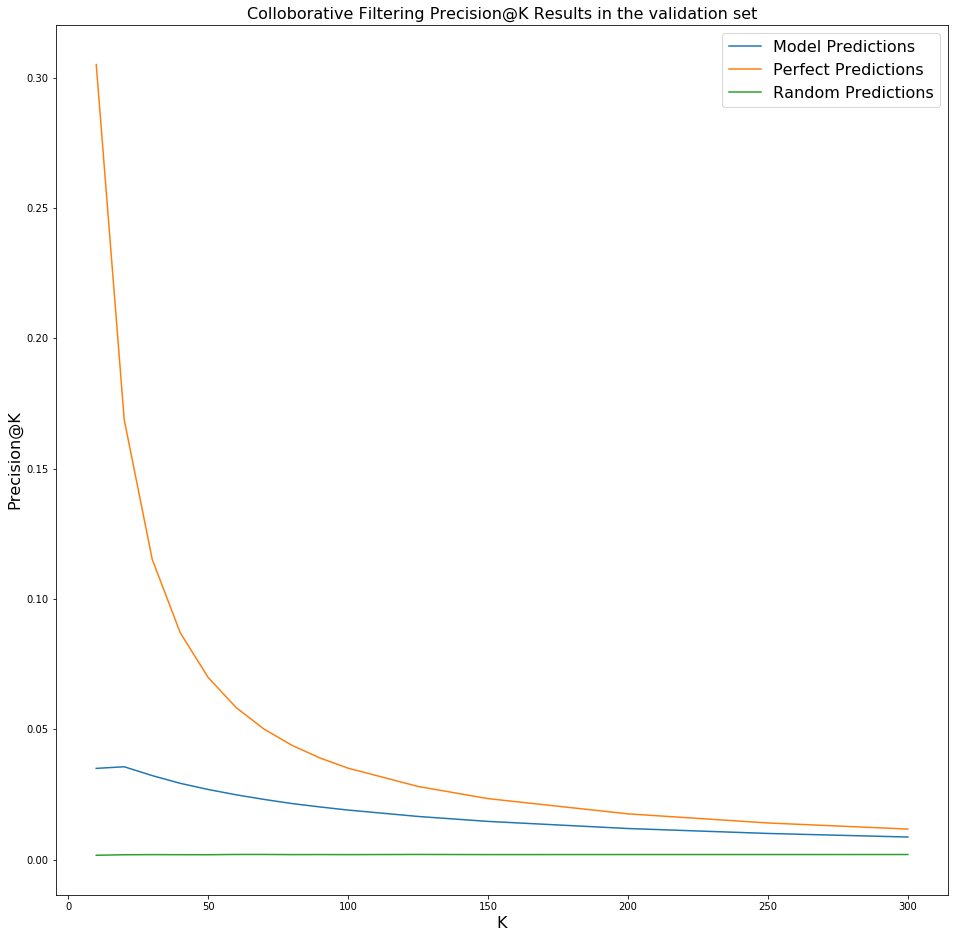

In [103]:
x = [10,20,30,40,50,60,70,80,90,100,125,150,200,250,300]
fig, ax = plt.subplots(figsize=(16, 16))

ax.plot(x, precisionK)
ax.plot(x, bestK)
ax.plot(x, randomK)
plt.ylabel('Precision@K',fontsize=16)
plt.xlabel('K',fontsize=16)
plt.legend(['Model Predictions','Perfect Predictions','Random Predictions'],fontsize=16)
# plt.ylim(0,0.06)
plt.title('Colloborative Filtering Precision@K Results in the validation set',fontsize=16)
plt.show()

In [114]:
cf_test.shape

(88335, 6)

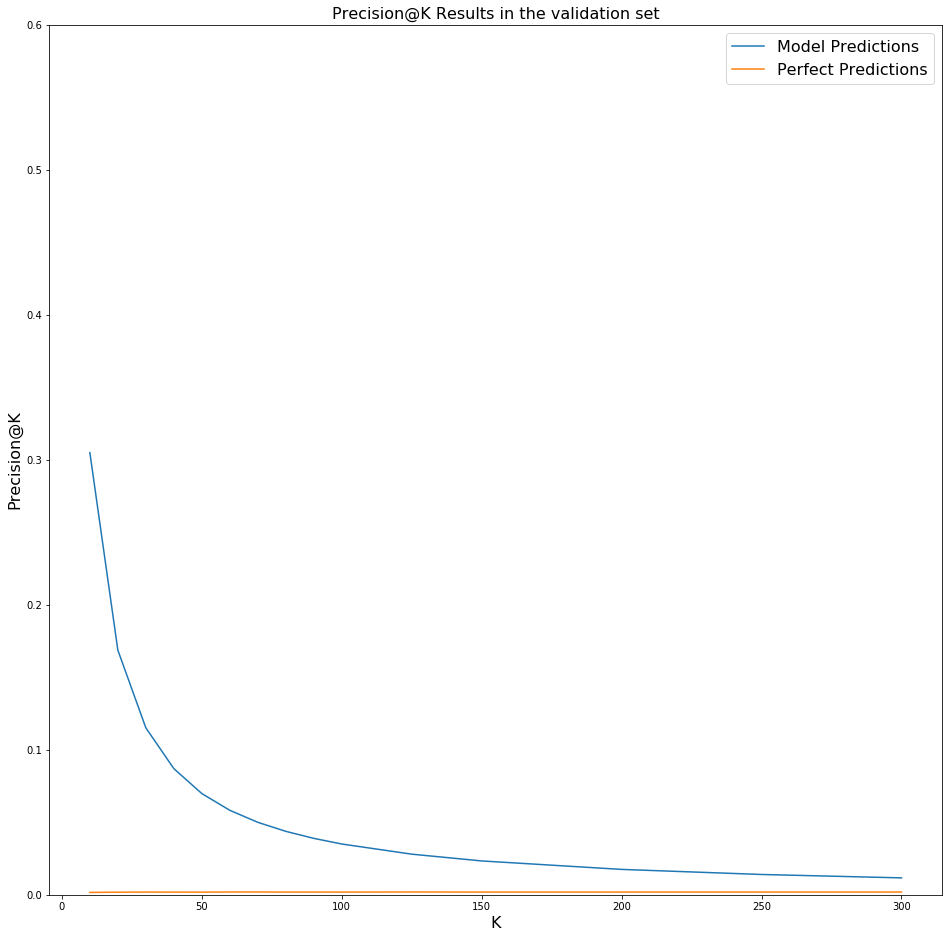

In [107]:
x = [10,20,30,40,50,60,70,80,90,100,125,150,200,250,300]
fig, ax = plt.subplots(figsize=(16, 16))

ax.plot(x, precisionK_cb)
# ax.plot(x, bestK)
ax.plot(x, randomK)
plt.ylabel('Precision@K',fontsize=16)
plt.xlabel('K',fontsize=16)
plt.legend(['Model Predictions','Perfect Predictions','Random Predictions'],fontsize=16)
plt.ylim(0,0.6)
plt.title('Precision@K Results in the validation set',fontsize=16)
plt.show()

In [109]:
prec_all/enum

0.011656441717791437

In [110]:
best_case/enum

0.4069372345446034

In [111]:
random_case/enum

0.008117036337895227

In [72]:
print(tp_all,fp_all,err)
tp_all/(tp_all+fp_all) # Precision@user_rated_movies in the test set

3235 7064 0


0.3141081658413438

---

In [15]:
test_acc = []
test_loss = []
test_gt = []
test_pr = []

In [18]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    _check_restore_parameters(sess, saver)
    
    # TEST SET
    test_acc_ = []
    test_loss_ = []
    test_batch_gt = np.empty((0,1), float)
    test_batch_score = np.empty((0,1), float)
    for audio_test, image_test, user_test, y_test_ in batch_generator(val, recmodel.df_audio_val, recmodel.df_image_val, recmodel.user_latent_traninig, batchsize=val.shape[0]//batch_size):
        # Feed
        y_test = np.expand_dims(y_test_, 1)
        feed = {model.inputs_image : image_test, model.inputs_audio : audio_test, model.inputs_user : user_test, 
                model.labels_ : y_test, model.keep_prob_ : 1.0}  

        # Loss
        loss_t, acc_t, logs_t, labs_t, _gt_t, _pr_t = sess.run([model.cost, model.accuracy,model.logits,model.labels_,model.gt_ , model.pr_], feed_dict = feed)                    
        test_acc_.append(acc_t)
        test_loss_.append(loss_t)

        test_batch_gt = np.append(test_batch_gt, _gt_t, axis=0)
        test_batch_score = np.append(test_batch_score, _pr_t, axis=0)

    # Store test
    test_acc.append(np.mean(test_acc_))
    test_loss.append(np.mean(test_loss_))

    test_gt.append(test_batch_gt)
    test_pr.append(test_batch_score)

Loading parameters for the RatingModel
INFO:tensorflow:Restoring parameters from checkpoints/RatingModel-300


In [19]:
test_loss

[0.6891635, 0.6505559]

In [11]:
batch_size=64

In [27]:
tf.reset_default_graph()  
imported_meta = tf.train.import_meta_graph("./model/rating/-300.meta")  

In [33]:
import tensorflow as tf
from multimodalrec.multimodalrec import rating_model

graph, inputs_image, inputs_audio, inputs_user, labels_, keep_prob_, learning_rate_, \
logits, cost, optimizer, correct_pred, accuracy, f1score, gt_ , pr_ = rating_model(data_source = "A+I", 
                                                                         concat_type = 'Multiplicative', 
                                                                         conv_type='Both', 
                                                                         batch_size = 64, 
                                                                         seq_len = 60, 
                                                                         learning_rate = 0.00008, 
                                                                         epochs = 1, 
                                                                         n_channels_user = 100, 
                                                                         n_classes = 1, 
                                                                         n_channels_audio = 100, 
                                                                         n_channels_image = 2048)
# new_graph = tf.Graph()
# This works
sess = tf.Session()   
sess.run(tf.global_variables_initializer())
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('./model/rating/-300.meta')
saver.restore(sess,tf.train.latest_checkpoint('./model/rating/'))

# TEST SET
test_acc_ = []
test_loss_ = []
test_batch_gt = np.empty((0,1), float)
test_batch_score = np.empty((0,1), float)
for audio_test, image_test, user_test, y_test_ in batch_generator(test, recmodel.df_audio_test, recmodel.df_image_test, recmodel.user_latent_traninig, batchsize=test.shape[0]//batch_size):
    # Feed
    y_test = np.expand_dims(y_test_, 1)
    feed = {inputs_image : image_test, inputs_audio : audio_test, inputs_user : user_test, 
            labels_ : y_test, keep_prob_ : 1.0}  

    # Loss
    loss_t, acc_t, logs_t, labs_t, _gt_t, _pr_t = sess.run([cost, accuracy,logits,labels_,gt_ , pr_], feed_dict = feed)                    
    test_acc_.append(acc_t)
    test_loss_.append(loss_t)

    test_batch_gt = np.append(test_batch_gt, _gt_t, axis=0)
    test_batch_score = np.append(test_batch_score, _pr_t, axis=0)

# Store test
test_acc.append(np.mean(test_acc_))
test_loss.append(np.mean(test_loss_))

test_gt.append(test_batch_gt)
test_pr.append(test_batch_score)

Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Tensor("add_1:0", shape=(?, 64), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model/rating/-300


TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("inputs_image:0", shape=(?, 60, 2048), dtype=float32) is not an element of this graph.

In [55]:
test_loss

[0.691446, 0.7008478, 0.708824, 0.71522814, 0.6923732, 0.6907573, 0.69635934]

In [54]:
test_acc

[0.5614019,
 0.47578728,
 0.47578728,
 0.47578728,
 0.51766896,
 0.5243528,
 0.47578728]

In [5]:
dict_c_type_run_lr8 = {}

for c_type in ['Multiplicative','Additive','Multiplicative_Image','User']:
    print('\n',c_type,'\n')
    validation_gt, validation_pr, validation_acc, \
    validation_loss, train_acc, train_loss, \
    test_gt, test_pr, test_acc, test_loss = recmodel.train_rating_prediction(train=train,
                                                                             val=val,
                                                                             test=test,
                                                                             data_source = "A+I", 
                                                                             concat_type = c_type, 
                                                                             conv_type='Both', 
                                                                             batch_size = 64, 
                                                                             seq_len = 60, 
                                                                             max_iter=2501,
                                                                             learning_rate = 0.00008, 
                                                                             epochs = 1, 
                                                                             n_channels_user = 100, 
                                                                             n_classes = 1, 
                                                                             n_channels_audio = 100, 
                                                                             n_channels_image = 2048)
    run = (validation_gt, validation_pr, validation_acc, \
               validation_loss, train_acc, train_loss, \
               test_gt, test_pr, test_acc, test_loss)
    dict_c_type_run_lr8[c_type] = run


 Multiplicative 

Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Tensor("add_1:0", shape=(?, 64), dtype=float32)
Train, Validation, Test shapes: (2539397, 4) (99562, 4) (21647, 4)
Epoch: 0/1 Iteration: 1 Validation loss: 0.691717 Validation acc: 0.553322 Validation F1 score: 0.000000
Epoch: 0/1 Iteration: 20 Train loss: 0.691948 Train acc: 0.531250
Epoch: 0/1 Iteration: 40 Train loss: 0.703457 Train acc: 0.500000
Epoch: 0/1 Iteration: 60 Train loss: 0.690276 Train acc: 0.531250
Epoch: 0/1 Iteration: 80 Train loss: 0.688992 Train acc: 0.562500
Epoch: 0/1 Iteration: 100 Train loss: 0.682577 Train acc: 0.546875
Epoch: 0/1 Iteration: 100 Validation loss: 0.687960 Validation acc: 0.553322 Validation F1 score: 0.712438
This iteration receive better loss: 0.688 < 0.692. Saving session...
Epoch: 0/1 Iteration: 120 Train loss: 0.695650 Train acc: 0.515625
Epoch: 0/1 Iteration: 140 Train loss: 0.696660 T

In [52]:
y_test_list = []
y_pred_test_list = []
for audio_test, image_test, user_test, y_test_ in  batch_generator(test, recmodel.df_audio_test, recmodel.df_image_test, recmodel.user_latent_traninig, batchsize=128):
    y_test = np.expand_dims(y_test_, 1)
    y_pred_test = np.ones_like(y_test)
    
    y_test_list.append(y_test)
    y_pred_test_list.append(y_pred_test)
    #break
# y_test_list

In [53]:
np.concatenate(y_test_list, axis=0).shape

(21647, 1)

In [54]:
np.concatenate(y_pred_test_list, axis=0).shape

(21647, 1)

In [183]:
def compute_baselines(recmodel, train, test, multimodal_type, run_random_state=123):
    audio_train, image_train, user_train, y_train_ = val_batch_generator(train, recmodel.df_audio, recmodel.df_image, recmodel.user_latent_traninig, batchsize=200)
    y_train = np.expand_dims(y_train_, 1)
    
    if multimodal_type == 'Ones':
        
        #train_acc_list = []
        y_test_list = []
        y_pred_test_list = []
        test_acc_list = []

        y_pred_train = np.zeros_like(y_train)
        #train_acc = accuracy_score(y_train.reshape(y_train.shape[0]*y_train.shape[1]), y_pred_train.reshape(y_pred_train.shape[0]*y_pred_train.shape[1]))
        train_acc = accuracy_score(y_train, y_pred_train)
        train_loss = 0
        
        for audio_test, image_test, user_test, y_test_ in  batch_generator(test, recmodel.df_audio_test, recmodel.df_image_test, recmodel.user_latent_traninig, batchsize=128):
            y_test = y_test_ #np.expand_dims(y_test_, 1)
            y_pred_test = np.zeros_like(y_test)
            
            test_acc = accuracy_score(y_test, y_pred_test)
            test_loss = 0
            
            y_test_list.append(y_test)
            y_pred_test_list.append(y_pred_test)
            test_acc_list.append(test_acc)

        run_results = (None, None, None, \
                       None, train_acc, train_loss, \
                       np.concatenate(y_test_list, axis=0), np.concatenate(y_pred_test_list,axis=0), np.mean(test_acc_list), test_loss)
        
    elif multimodal_type == 'Random_Dist':

        np.random.seed(run_random_state)
        
        y_test_list = []
        y_pred_test_list = []
        test_acc_list = []

        label_randomness = np.count_nonzero(y_train[:,0], axis=0)/y_train[:,0].shape[0]
        y_pred_train = np.random.choice([1, 0], size=(y_train[:,0].shape[0],), p=[1. - label_randomness, label_randomness])
        
        train_acc = accuracy_score(y_train, y_pred_train)
        train_loss = 0
        
        for audio_test, image_test, user_test, y_test_ in  batch_generator(test, recmodel.df_audio_test, recmodel.df_image_test, recmodel.user_latent_traninig, batchsize=128):
            y_test = y_test_ #np.expand_dims(y_test_, 1)
            y_pred_test = np.random.choice([1, 0], size=(y_test.shape[0],), p=[1. - label_randomness, label_randomness])
            test_acc = accuracy_score(y_test, y_pred_test)
            test_loss = 0
        
            y_test_list.append(y_test)
            y_pred_test_list.append(y_pred_test)
            test_acc_list.append(test_acc)

        run_results = (None, None, None, \
           None, train_acc, train_loss, \
           np.concatenate(y_test_list, axis=0), np.concatenate(y_pred_test_list,axis=0), np.mean(test_acc_list), test_loss)
    
    return run_results

In [184]:
all_runs_zero_prediction = compute_baselines(recmodel, train, test, 'Ones')

In [185]:
print(accuracy_score(all_runs_zero_prediction[6], all_runs_zero_prediction[7]))

0.5242296854067539


In [186]:
ones = (f1_score(all_runs_zero_prediction[6], all_runs_zero_prediction[7]),
precision_score(all_runs_zero_prediction[6], all_runs_zero_prediction[7]),
recall_score(all_runs_zero_prediction[6], all_runs_zero_prediction[7]))

/anaconda3/envs/muteferrika/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/muteferrika/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [187]:
all_runs_random_distribution = compute_baselines(recmodel, train, test, 'Random_Dist')
print(accuracy_score(all_runs_random_distribution[6], all_runs_random_distribution[7]))
rands = (f1_score(all_runs_random_distribution[6], all_runs_random_distribution[7]),
precision_score(all_runs_random_distribution[6], all_runs_random_distribution[7]),
recall_score(all_runs_random_distribution[6], all_runs_random_distribution[7]))

0.4943410172310251


In [188]:
Counter(all_runs_zero_prediction[6])

Counter({1: 10299, 0: 11348})

In [196]:
mean_dct = {}
for _year_ in dict_c_type_run_lr8.keys():
    (validation_gt, validation_pr, validation_acc, \
     validation_loss, train_acc, train_loss, \
     test_gt, test_pr, test_acc, test_loss) = dict_c_type_run_lr8[_year_]
    #best = max([(ind,v) for ind, v in enumerate(validation_acc)], key=lambda x:x[1])
    #best = max([(ind,v) for ind, v in enumerate(validation_acc2)], key=lambda x:x[1])
    best = min([(ind,v) for ind, v in enumerate(validation_loss)], key=lambda x:x[1])
    print(best,_year_)
    val_batch_score = test_pr[best[0]] #validation_pr[best[0]]
    val_batch_gt = test_gt[best[0]] # validation_gt[best[0]]
    
    f1 = f1_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    prec = precision_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    recall = recall_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    
    mean_dct[str(_year_)] = (f1,prec,recall)
    

(14, 0.60652846) Multiplicative
(15, 0.67172223) Additive
(16, 0.6276334) Multiplicative_Image
(25, 0.6883792) User


In [197]:
mean_dct['Ones'] = ones
mean_dct['Random'] = rands

In [198]:
mean_dct

{'Multiplicative': (0.6337036873091054,
  0.5823299707126587,
  0.6950189338770755),
 'Additive': (0.6447755587553998, 0.4757703145932462, 1.0),
 'Multiplicative_Image': (0.6194083541410978,
  0.548987246811703,
  0.7105544227594912),
 'User': (0.6447755587553998, 0.4757703145932462, 1.0),
 'Ones': (0.0, 0.0, 0.0),
 'Random': (0.44436548223350253, 0.4655887671524306, 0.42499271773958636)}

In [199]:
overall_df_mean = pd.DataFrame(mean_dct).T
overall_df_mean.columns = ['F1', 'Precision', 'Recall']
overall_df_mean

,F1,Precision,Recall
Multiplicative,0.633704,0.582330,0.695019
Additive,0.644776,0.475770,1.000000
Multiplicative_Image,0.619408,0.548987,0.710554
User,0.644776,0.475770,1.000000
Ones,0.000000,0.000000,0.000000
Random,0.444365,0.465589,0.424993


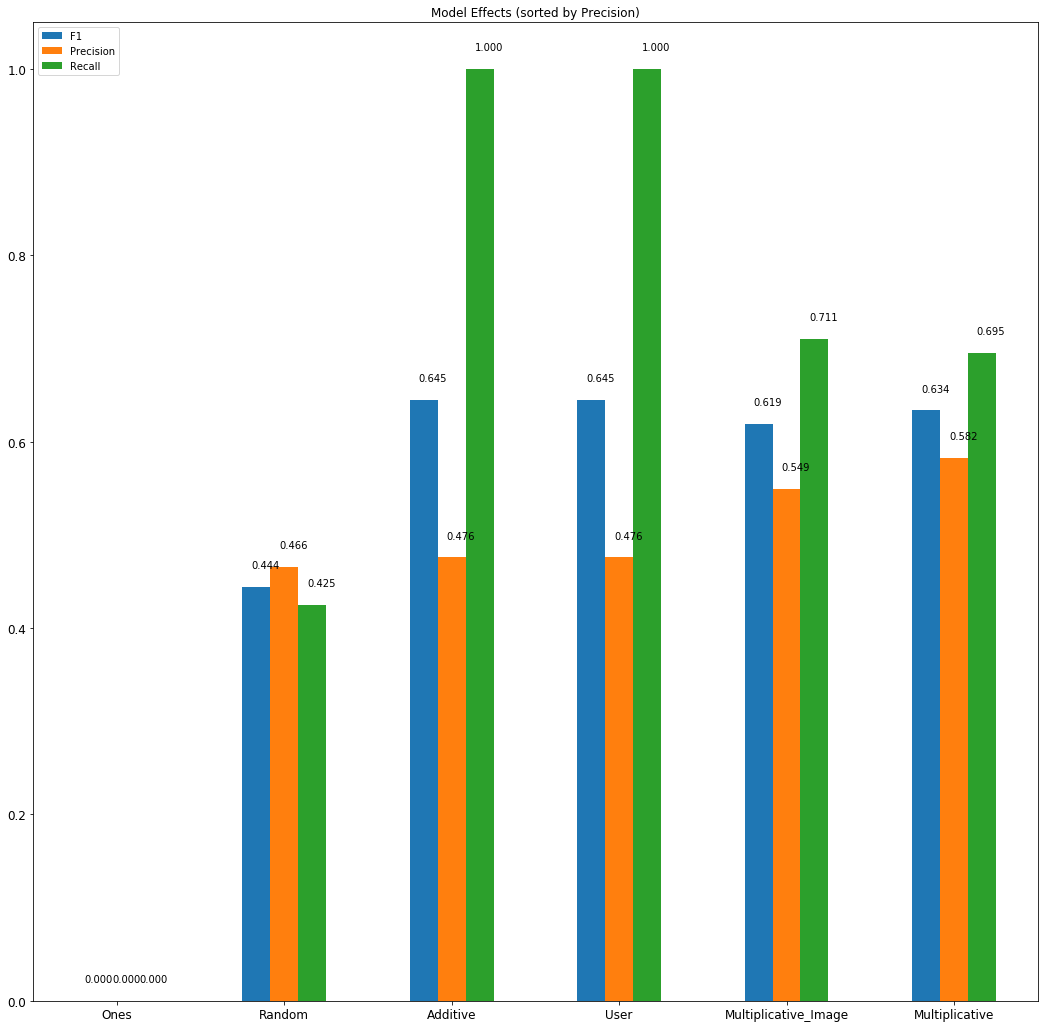

In [201]:
ax = overall_df_mean.sort_values('Precision').plot(kind='bar', title ="Model Effects (sorted by Precision)", figsize=(18, 18), legend=True, fontsize=12,)
plt.xticks(rotation=0)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper left')

x_offset = -0.03
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.3f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
plt.show()

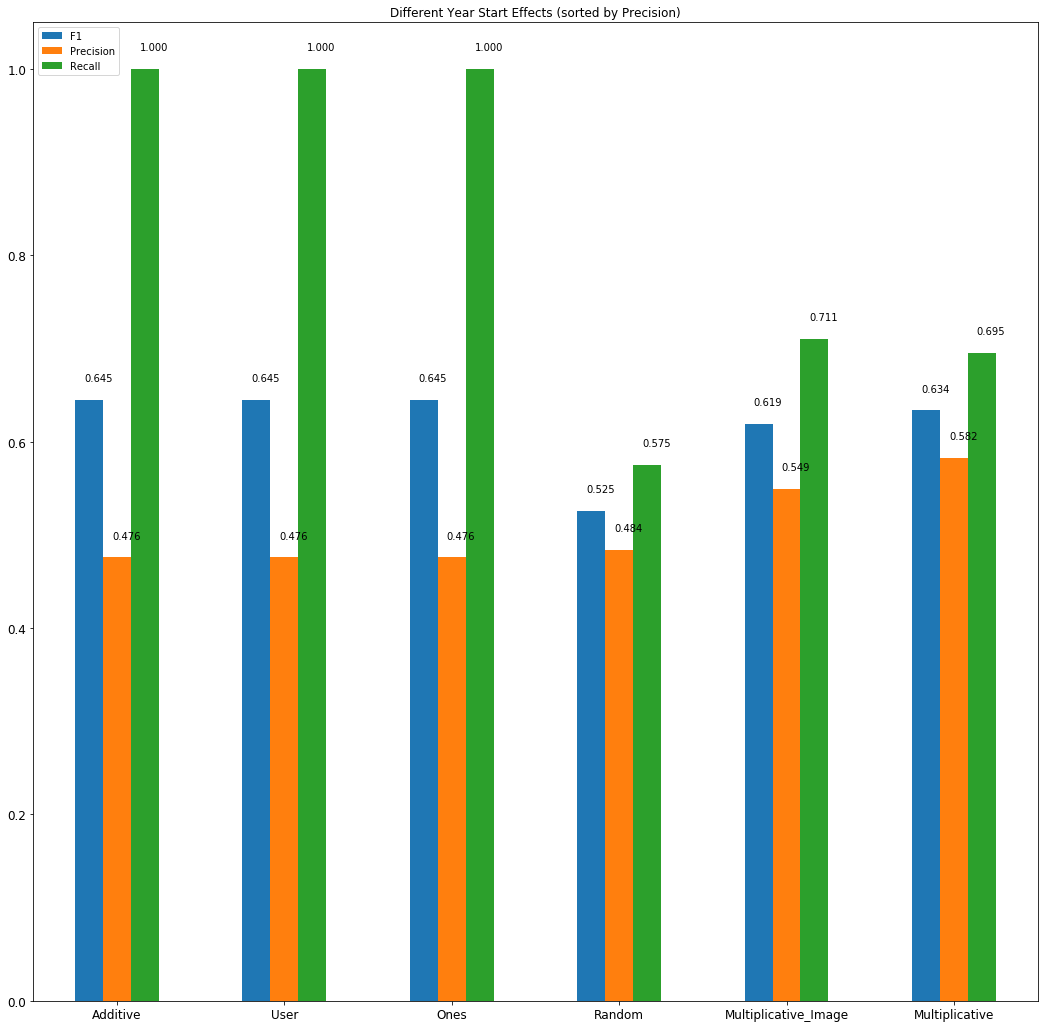

In [74]:
ax = overall_df_mean.sort_values('Precision').plot(kind='bar', title ="Different Year Start Effects (sorted by Precision)", figsize=(18, 18), legend=True, fontsize=12,)
plt.xticks(rotation=0)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper left')

x_offset = -0.03
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.3f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
plt.show()

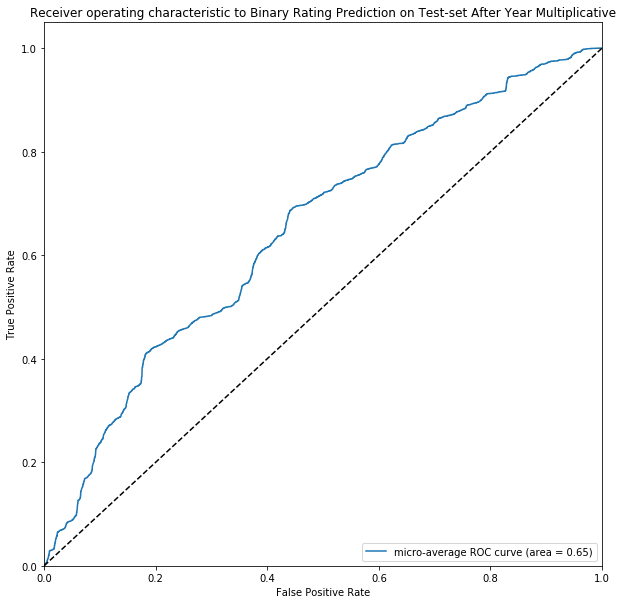

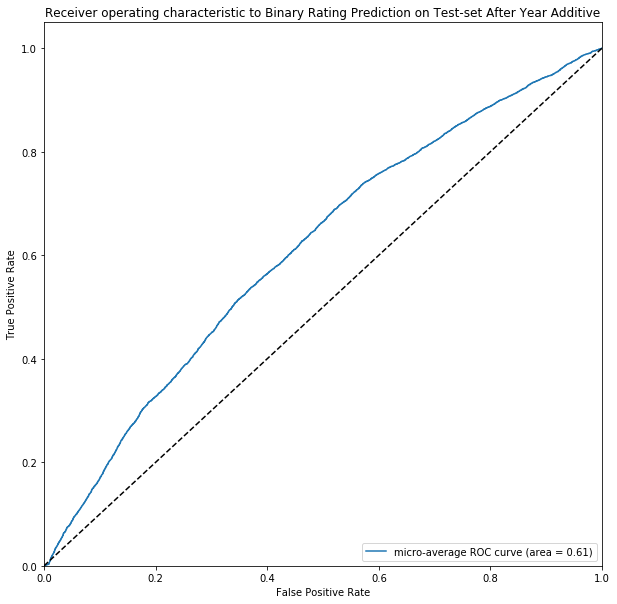

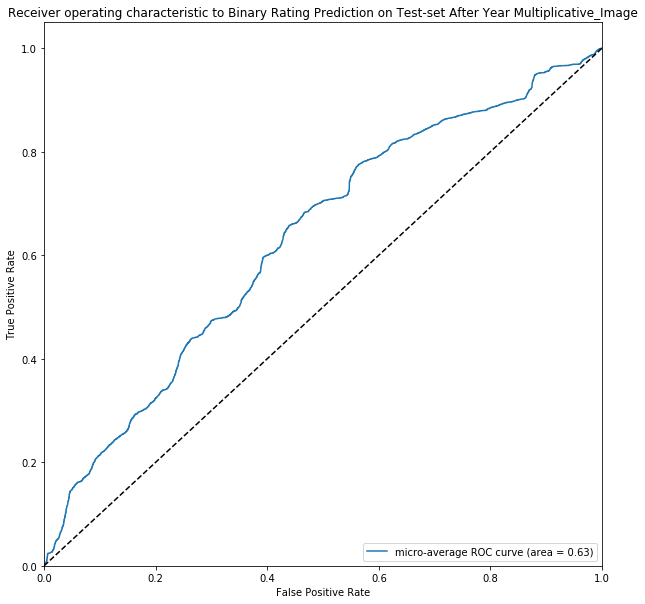

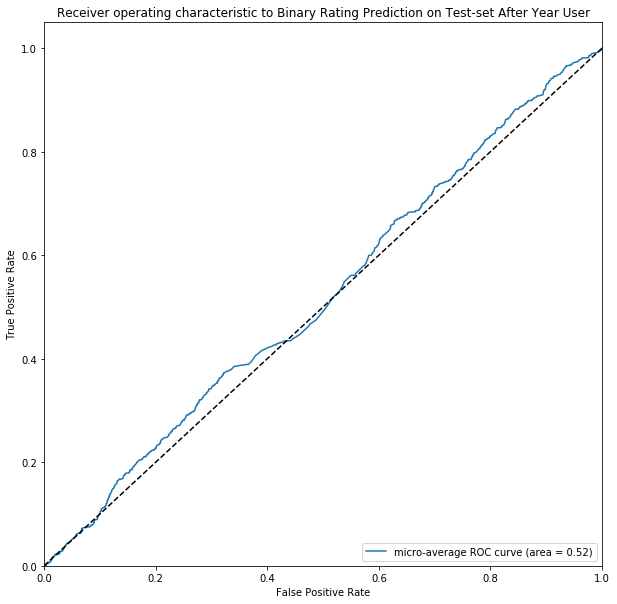

In [77]:
for _year_ in dict_c_type_run_lr8.keys():
    (validation_gt, validation_pr, validation_acc, \
     validation_loss, train_acc, train_loss, \
     test_gt, test_pr, test_acc, test_loss) = dict_c_type_run_lr8[_year_]
    #best = max([(ind,v) for ind, v in enumerate(validation_acc)], key=lambda x:x[1])
    #best = max([(ind,v) for ind, v in enumerate(validation_acc2)], key=lambda x:x[1])
    best = min([(ind,v) for ind, v in enumerate(validation_loss)], key=lambda x:x[1])
    val_batch_score = test_pr[best[0]] #validation_pr[best[0]]
    val_batch_gt = test_gt[best[0]] # validation_gt[best[0]]
    
    f1 = f1_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    prec = precision_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    recall = recall_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1):
        fpr[i], tpr[i], _ = roc_curve(val_batch_gt[:, i], val_batch_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(val_batch_gt.ravel(), val_batch_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #Plot ROC curve
    plt.figure(figsize=(10,10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    #for i in range(n_classes):
    # plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
    #                                    ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to Binary Rating Prediction on Test-set After Year '+str(_year_))
    plt.legend(loc="lower right")
    plt.show()

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Precision@N - Recommendation Comparison

In [346]:
train = ratings_df_training_filtered[ratings_df_training_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
val   = ratings_df_val_filtered[ratings_df_val_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
test  = ratings_df_test_filtered[ratings_df_test_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
train = train[train.Movie.isin(list(recmodel.df_audio.keys()))].copy()
val   = val[val.Movie.isin(list(recmodel.df_audio_val.keys()))].copy()
test  = test[test.Movie.isin(list(recmodel.df_audio_test.keys()))].copy()

### Standard CF

In [101]:
from multimodalrec.viewership import CollaborativeFiltering, _svd_compute
# from sklearn.model_selection import train_test_split

In [111]:
cf_train = train.sample(frac=0.85)
cf_test = train.loc[~train.index.isin(cf_train.index)]

In [117]:
user_item_network_training = CollaborativeFiltering(cf_train)

The sparsity level of training dataset is 99.4%


In [119]:
# User_representations, Movie_representations, sigma = user_item_network_training.compute_latent_factors(k=100)
(U, sigma, Vt) = _svd_compute(user_item_network_training.Ratings_demeaned, k=100)

In [139]:
sigma = np.diag(sigma)

In [140]:
print(U.shape)
print(Vt.T.shape)
print(sigma.shape)

(61869, 100)
(6247, 100)
(100, 100)


In [141]:
user_ratings_mean = np.mean(user_item_network_training.R, axis = 1)

In [142]:
user_ratings_mean.reshape(-1, 1).shape

(61869, 1)

In [144]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [219]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = user_item_network_training.Ratings.columns, index = user_item_network_training.Ratings.index)
preds.head()

Movie,1,2,6,7,10,11,12,13,14,16,...,49314,49347,49355,49526,49530,49642,49649,49651,49824,50064
User,,,,,,,,,,,,,,,,,,,,,
1,-0.237404,0.964729,0.047647,0.223822,0.949353,0.543186,0.093116,0.094468,0.026877,0.071680,...,-0.005388,-0.004146,-0.006011,-0.004781,-0.002622,-0.006503,-0.005831,-0.002606,-0.005292,-0.004950
2,-0.006453,-0.019430,-0.007282,0.002225,-0.057530,-0.031228,-0.003237,-0.007782,0.024311,-0.032616,...,-0.000055,-0.000328,0.000134,-0.000012,-0.000572,0.000394,-0.000170,-0.001182,0.001504,-0.000011
3,0.021860,-0.012111,0.030959,0.002963,0.051878,0.065622,-0.020320,-0.008478,-0.003805,0.016152,...,-0.000865,0.001384,-0.000541,-0.000726,-0.000520,-0.000153,-0.000289,-0.000324,-0.001327,-0.000505
4,0.056227,1.197110,-0.501593,-0.062426,0.986410,0.293420,-0.009081,0.089040,-0.000456,0.037335,...,-0.001235,-0.002050,-0.001375,-0.000444,-0.002411,-0.002559,-0.000586,-0.005446,-0.000723,0.000162
5,1.014770,-0.078004,-0.278127,0.063842,0.034916,-0.009419,0.022575,-0.005905,0.090859,-0.006561,...,0.001495,0.000238,0.003630,0.001253,0.006083,0.003095,0.002281,0.000701,0.001873,0.002177


In [155]:
movies = recmodel.data['Titles']
ratings = recmodel.data['training']

In [270]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    try:
        top_nrecs = predictions.iloc[userID-1].sort_values(ascending=False).index.tolist()[:num_recommendations]
    except:
        return []
    return top_nrecs
def precision(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

In [282]:
tp_all=0
fp_all=0
err=0
prec_all=0
enum=0
for usr in tqdm.tqdm(cf_test[cf_test.User.isin(cf_train.User.unique().tolist())].User.unique().tolist(),position=0):
    recommendations = recommend_movies(preds, usr, movies, ratings, 100)
    
    movies_recommended = recommendations#.MovieID.tolist()
    if movies_recommended != []: 
        
        movies_already_rated = cf_test[(cf_test.User==usr)&(cf_test.Rating>4.0)].Movie.tolist()

        tp = len(set(movies_already_rated) & set(movies_recommended)) #len(movies_already_rated) - len(set(movies_already_rated)- set(movies_recommended))
        fp = len(movies_already_rated) - len(set(movies_already_rated) & set(movies_recommended)) #len(set(movies_already_rated)- set(movies_recommended))
        
        if len(movies_already_rated)!=0:
            prec_all+=precision(movies_already_rated, movies_recommended, len(movies_already_rated)) * len(movies_already_rated)
            enum+=len(movies_already_rated)
        tp_all+=tp
        fp_all+=fp
    else:
        err+=1
    # print('Precision@100 for user:',usr,float(tp)/(float(tp+fp)+.00000000001))
    

100%|██████████| 54028/54028 [02:18<00:00, 389.62it/s]


In [284]:
prec_all/enum

0.029146073071341747

In [283]:
print(tp_all,fp_all,err)

28924 157825 7432


In [285]:
tp_all/(tp_all+fp_all) # Precision@user_rated_movies in the test set

0.15488168611344638

### Content-Based Approach

In [386]:
# dict_c_type_run_lr8['Multiplicative']
_year_='Multiplicative'
(validation_gt, validation_pr, validation_acc, \
 validation_loss, train_acc, train_loss, \
 test_gt, test_pr, test_acc, test_loss) = dict_c_type_run_lr8[_year_]
#best = max([(ind,v) for ind, v in enumerate(validation_acc)], key=lambda x:x[1])
#best = max([(ind,v) for ind, v in enumerate(validation_acc2)], key=lambda x:x[1])
best = min([(ind,v) for ind, v in enumerate(validation_loss)], key=lambda x:x[1])
print(best,_year_)
val_batch_score = test_pr[best[0]] #validation_pr[best[0]]
val_batch_gt = test_gt[best[0]] # validation_gt[best[0]]

# f1 = f1_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
# prec = precision_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
# recall = recall_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())

# mean_dct[str(_year_)] = (f1,prec,recall)

(14, 0.60652846) Multiplicative


In [387]:
val_batch_score

array([[0.49082702],
       [0.62582767],
       [0.51742083],
       ...,
       [0.42726547],
       [0.56286269],
       [0.60064602]])

In [388]:
val_batch_gt[:10].ravel()

array([1., 1., 1., 0., 1., 0., 1., 1., 0., 1.])

In [389]:
cb_test = test.copy()
cb_test['gt'] = val_batch_gt.ravel()
cb_test['score'] = val_batch_score.ravel()
cb_test['score'] = val_batch_score.ravel()
cb_test.head(10)

,User,Movie,Rating,Timestamp,gt,score
53,8481,50601,4.5,2008-11-14 20:24:48,1.0,0.490827
221,67385,58559,4.5,2008-07-23 07:19:43,1.0,0.625828
516,34081,55276,4.5,2008-02-25 03:52:24,1.0,0.517421
1319,62101,50162,2.5,2007-03-19 02:21:31,0.0,0.459081
1330,26346,51084,5.0,2007-12-22 20:41:07,1.0,0.414488
1351,16453,50802,1.5,2007-11-07 02:08:04,0.0,0.278596
2809,33780,55820,5.0,2008-03-26 06:40:59,1.0,0.711740
2849,51459,55765,4.5,2008-01-14 22:31:45,1.0,0.542393
3004,32021,55603,2.5,2008-10-14 18:34:32,0.0,0.216522
3761,37442,52973,4.5,2008-05-02 00:40:22,1.0,0.369020


In [25]:
cb_test['gt'] = synt_test['Score'] = [e[0] for e in list(synt_test_gt[0])] 
cb_test.head(10)

,User,Movie,Rating,Timestamp,Score,gt
4554114,2755,733,5.0,1997-07-13 07:03:40,0.732503,1.0
4554123,21013,519,2.0,1996-10-18 02:34:39,0.291650,0.0
4554128,18717,911,5.0,2005-04-18 03:15:43,0.832793,1.0
4554131,66883,1259,5.0,1996-11-27 16:52:28,0.736052,1.0
4554133,60378,2655,2.0,2000-10-24 17:31:58,0.407361,0.0
4554134,3597,3273,1.0,2000-12-13 01:48:56,0.257628,0.0
4554135,44350,527,4.5,2006-06-16 19:55:11,0.932836,1.0
4554136,29305,1240,4.5,2004-12-16 18:42:34,0.768763,1.0
4554137,39063,7438,4.5,2005-07-24 00:44:26,0.586111,1.0
4554138,31642,45,5.0,1996-07-03 20:12:53,0.374785,1.0


In [390]:
cb_test[cb_test.User==8481].sort_values('score',ascending=False)

,User,Movie,Rating,Timestamp,gt,score
3469183,8481,57669,4.5,2008-11-14 20:48:35,1.0,0.756420
7328481,8481,56607,4.5,2008-11-15 18:38:09,1.0,0.637811
1334282,8481,56165,2.0,2008-11-15 18:38:52,0.0,0.564274
4306301,8481,54190,4.5,2008-11-14 20:24:33,1.0,0.520238
1513888,8481,56775,2.5,2008-11-15 18:43:25,0.0,0.519988
881682,8481,56367,5.0,2008-11-14 20:23:13,1.0,0.505347
53,8481,50601,4.5,2008-11-14 20:24:48,1.0,0.490827
1996823,8481,58103,2.5,2008-11-15 18:36:08,0.0,0.467140
2206194,8481,54999,2.5,2008-11-14 20:28:26,0.0,0.454851
4867916,8481,56145,2.5,2008-11-14 20:28:49,0.0,0.436826


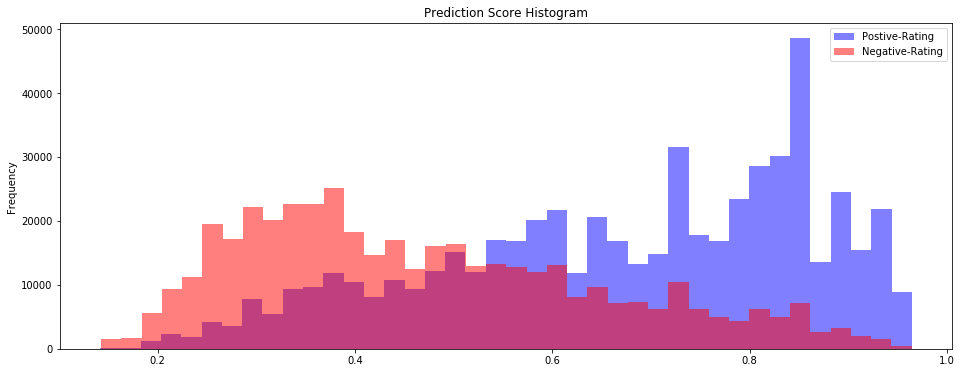

In [27]:
fig, ax = plt.subplots(figsize=(16, 6))

cb_test[cb_test['gt']==1]['Score'].plot(kind='hist',bins=40,color='blue',ax=ax, alpha=0.5)
cb_test[cb_test['gt']==0]['Score'].plot(kind='hist',bins=40,color='red',ax=ax, alpha=0.5)
plt.legend(['Postive-Rating','Negative-Rating'])
plt.title('Prediction Score Histogram')
plt.show()

In [392]:
cb_test = test.copy()
cb_test['gt'] = val_batch_gt.ravel()
cb_test['score'] = val_batch_score.ravel()
# cb_test['rating_norm'] = cb_test.Rating/5.
cb_test.head(1)

,User,Movie,Rating,Timestamp,gt,score
53,8481,50601,4.5,2008-11-14 20:24:48,1.0,0.490827


In [393]:
val.shape

(99562, 4)

In [394]:
cb_train = pd.concat([train,val],axis=0)
# cb_train['gt'] = val_batch_gt.ravel()
# cb_train['score'] = val_batch_score.ravel()
cb_train['rating_norm'] = cb_train.Rating/5.
cb_train.head(1)

,User,Movie,Rating,Timestamp,rating_norm
1,25083,3418,5.0,2004-10-07 02:09:25,1.0


In [395]:
print(cb_test.shape)
print(cb_train.shape)

(21647, 6)
(2638959, 5)


In [411]:
cb_list = []
for usr in tqdm.tqdm(cb_test.User.unique().tolist(),position=0):
    user_df = cb_test[cb_test.User==usr]
    user_df_train = cb_train[cb_train.User==usr]
    try:
        usr_mean = user_df_train.rating_norm.mean() - .5
    except:
        usr_mean = 0.
    if math.isnan(usr_mean):
        usr_mean = 0.
    user_df['score_bias'] = user_df['score'].values + usr_mean
    cb_list.append(user_df)
    #break
cb_new_test = pd.concat(cb_list,axis=0)
cb_new_test.shape

  0%|          | 0/2471 [00:00<?, ?it/s]/anaconda3/envs/muteferrika/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 2471/2471 [04:38<00:00,  8.07it/s]


(21647, 7)

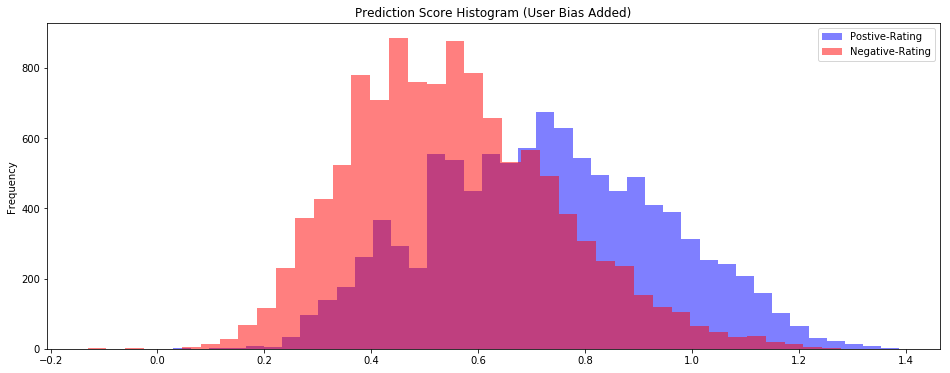

In [417]:
fig, ax = plt.subplots(figsize=(16, 6))

cb_new_test[cb_new_test['gt']==1]['score_bias'].plot(kind='hist',bins=40,color='blue',ax=ax, alpha=0.5)
cb_new_test[cb_new_test['gt']==0]['score_bias'].plot(kind='hist',bins=40,color='red',ax=ax, alpha=0.5)
plt.legend(['Postive-Rating','Negative-Rating'])
plt.title('Prediction Score Histogram (User Bias Added)')
plt.show()

In [425]:
# cb_new_test['score_bias']>6.2
def custom_pred(row, threshold=.62):
    if row['score_bias']>threshold:
        return 1.
    else:
        return 0.

cb_new_test['biased_pred'] = cb_new_test.apply(lambda row: custom_pred(row),axis=1)

In [427]:
# cb_new_test['biased_pred'] = cb_new_test['score_bias']
cb_new_test.tail()


,User,Movie,Rating,Timestamp,gt,score,score_bias,biased_pred
7413102,42834,52281,4.5,2007-09-02 10:07:43,1.0,0.419864,0.691794,1.0
7432414,14946,51540,4.5,2007-07-23 14:28:40,1.0,0.532357,0.867206,1.0
7450555,51907,55069,5.0,2008-03-26 11:39:58,1.0,0.675687,0.977076,1.0
7461604,32012,56367,4.5,2008-02-18 01:11:05,1.0,0.505588,0.568665,0.0
7469579,20222,50872,4.5,2007-11-14 03:36:20,1.0,0.728906,1.179573,1.0


**Adding to the `mean_dct`**

In [435]:
f1 = f1_score(cb_new_test['gt'].values.ravel(),cb_new_test['biased_pred'].ravel())
prec = precision_score(cb_new_test['gt'].values.ravel(),cb_new_test['biased_pred'].ravel())
recall = recall_score(cb_new_test['gt'].values.ravel(),cb_new_test['biased_pred'].ravel())
print(f1,prec,recall)
mean_dct['Multiplicative w/U-bias'] = (f1,prec,recall)

0.6624763705103969 0.6453365251818433 0.6805515098553258


### Test bias on User baseline model

In [436]:
# dict_c_type_run_lr8['Multiplicative']
_year_='User'
(validation_gt, validation_pr, validation_acc, \
 validation_loss, train_acc, train_loss, \
 test_gt, test_pr, test_acc, test_loss) = dict_c_type_run_lr8[_year_]
#best = max([(ind,v) for ind, v in enumerate(validation_acc)], key=lambda x:x[1])
#best = max([(ind,v) for ind, v in enumerate(validation_acc2)], key=lambda x:x[1])
best = min([(ind,v) for ind, v in enumerate(validation_loss)], key=lambda x:x[1])
print(best,_year_)
val_batch_score = test_pr[best[0]] #validation_pr[best[0]]
val_batch_gt = test_gt[best[0]] # validation_gt[best[0]]

# f1 = f1_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
# prec = precision_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
# recall = recall_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())

# mean_dct[str(_year_)] = (f1,prec,recall)

(25, 0.6883792) User


In [437]:
cb_test = test.copy()
cb_test['gt'] = val_batch_gt.ravel()
cb_test['score'] = val_batch_score.ravel()
# cb_test['rating_norm'] = cb_test.Rating/5.
cb_test.head(1)

,User,Movie,Rating,Timestamp,gt,score
53,8481,50601,4.5,2008-11-14 20:24:48,1.0,0.530487


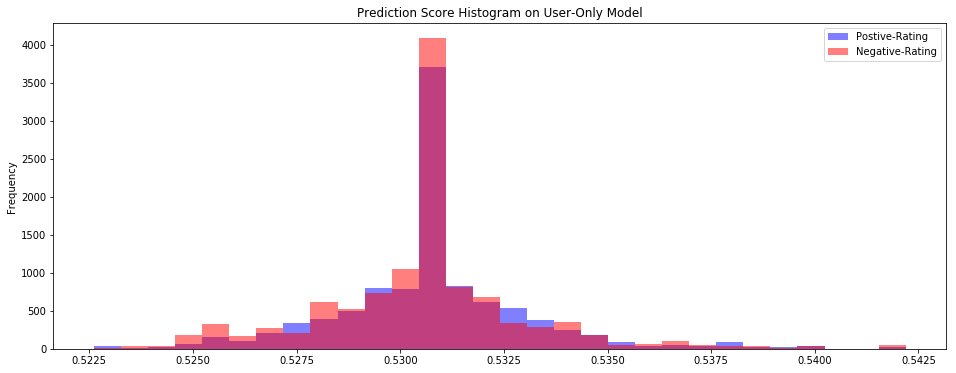

In [438]:
fig, ax = plt.subplots(figsize=(16, 6))

cb_test[cb_test['gt']==1]['score'].plot(kind='hist',bins=30,color='blue',ax=ax, alpha=0.5)
cb_test[cb_test['gt']==0]['score'].plot(kind='hist',bins=30,color='red',ax=ax, alpha=0.5)
plt.legend(['Postive-Rating','Negative-Rating'])
plt.title('Prediction Score Histogram on User-Only Model')
plt.show()

In [439]:
cb_list = []
for usr in tqdm.tqdm(cb_test.User.unique().tolist(),position=0):
    user_df = cb_test[cb_test.User==usr]
    user_df_train = cb_train[cb_train.User==usr]
    try:
        usr_mean = user_df_train.rating_norm.mean() - .5
    except:
        usr_mean = 0.
    if math.isnan(usr_mean):
        usr_mean = 0.
    user_df['only_bias'] = user_df['score'].values + usr_mean
    cb_list.append(user_df)
    #break
cb_new_test = pd.concat(cb_list,axis=0)
cb_new_test.shape

  0%|          | 0/2471 [00:00<?, ?it/s]/anaconda3/envs/muteferrika/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 2471/2471 [04:28<00:00,  8.76it/s]


(21647, 7)

In [441]:
cb_new_test.isna().sum()

User         0
Movie        0
Rating       0
Timestamp    0
gt           0
score        0
only_bias    0
dtype: int64

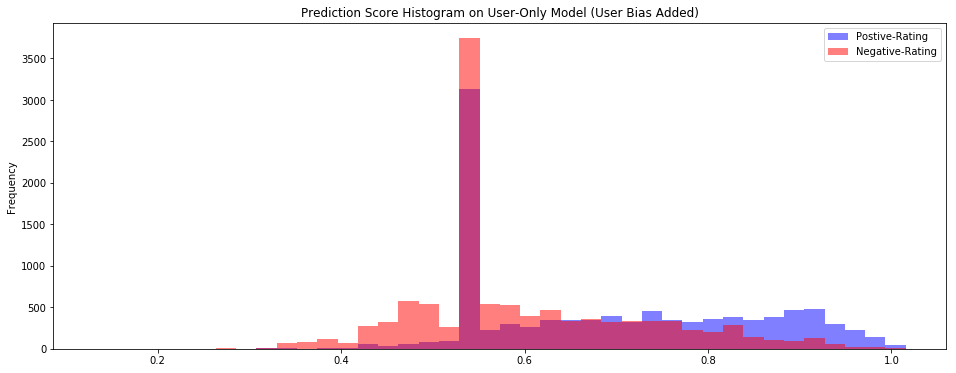

In [442]:
fig, ax = plt.subplots(figsize=(16, 6))

cb_new_test[cb_new_test['gt']==1]['only_bias'].plot(kind='hist',bins=40,color='blue',ax=ax, alpha=0.5)
cb_new_test[cb_new_test['gt']==0]['only_bias'].plot(kind='hist',bins=40,color='red',ax=ax, alpha=0.5)
plt.legend(['Postive-Rating','Negative-Rating'])
plt.title('Prediction Score Histogram on User-Only Model (User Bias Added)')
plt.show()

In [444]:
def custom_pred(row, threshold=.62):
    if row['only_bias']>threshold:
        return 1.
    else:
        return 0.
cb_new_test['biased_pred'] = cb_new_test.apply(lambda row: custom_pred(row),axis=1)

In [446]:
f1 = f1_score(cb_new_test['gt'].values.ravel(),cb_new_test['biased_pred'].ravel())
prec = precision_score(cb_new_test['gt'].values.ravel(),cb_new_test['biased_pred'].ravel())
recall = recall_score(cb_new_test['gt'].values.ravel(),cb_new_test['biased_pred'].ravel())
print(f1,prec,recall)
mean_dct['User w/U-bias'] = (f1,prec,recall)

0.5965613754498201 0.6146874034401071 0.5794737353141082


## Compare Results All of them

In [447]:
overall_df_mean = pd.DataFrame(mean_dct).T
overall_df_mean.columns = ['F1', 'Precision', 'Recall']
overall_df_mean

,F1,Precision,Recall
Multiplicative,0.633704,0.582330,0.695019
Additive,0.644776,0.475770,1.000000
Multiplicative_Image,0.619408,0.548987,0.710554
User,0.644776,0.475770,1.000000
Ones,0.000000,0.000000,0.000000
Random,0.444365,0.465589,0.424993
Multiplicative w/U-bias,0.662476,0.645337,0.680552
User w/U-bias,0.596561,0.614687,0.579474


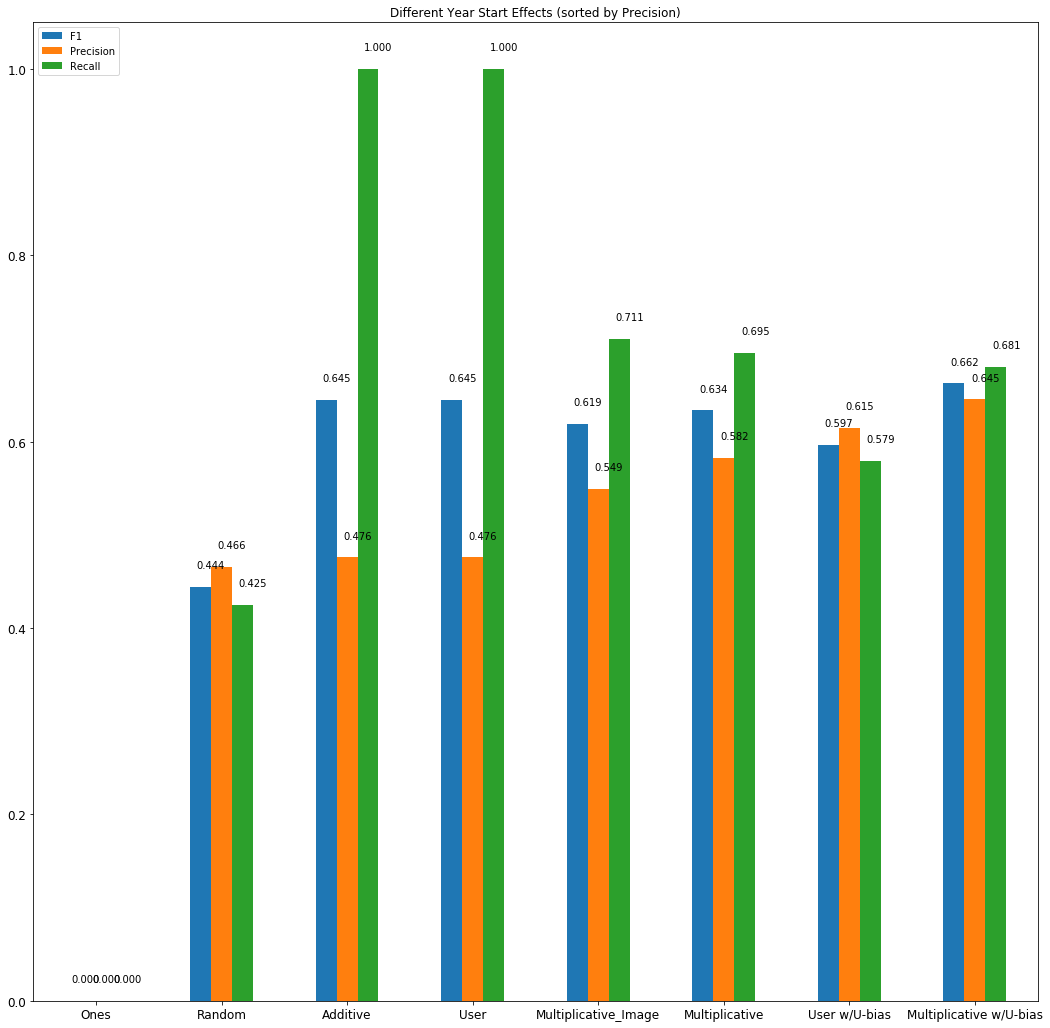

In [448]:
ax = overall_df_mean.sort_values('Precision').plot(kind='bar', title ="Different Year Start Effects (sorted by Precision)", figsize=(18, 18), legend=True, fontsize=12,)
plt.xticks(rotation=0)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper left')

x_offset = -0.03
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.3f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
plt.show()

Need to use best model to predict `all users` vs `all movies` and calculate the `precision@k` metrics for the *Content Based* Approach

In [450]:
print(test.User.nunique())
print(test.Movie.nunique())
print(test.User.nunique()*test.User.nunique())

2471
495
6105841


# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
dict_c_type_run_lr80 = {}

for c_type in ['Multiplicative','Additive','Multiplicative_Image','User']:
    print('\n',c_type,'\n')

    validation_gt, validation_pr, validation_acc, \
    validation_loss, train_acc, train_loss, \
    test_gt, test_pr, test_acc, test_loss = recmodel.train_rating_prediction(train=train,
                                                                             val=val,
                                                                             test=test,
                                                                             data_source = "A+I", 
                                                                             concat_type = c_type, 
                                                                             conv_type='Both', 
                                                                             batch_size = 64, 
                                                                             seq_len = 60, 
                                                                             max_iter=3001,
                                                                             learning_rate = 0.0008, 
                                                                             epochs = 1, 
                                                                             n_channels_user = 100, 
                                                                             n_classes = 1, 
                                                                             n_channels_audio = 100, 
                                                                             n_channels_image = 2048)
    run = (validation_gt, validation_pr, validation_acc, \
               validation_loss, train_acc, train_loss, \
               test_gt, test_pr, test_acc, test_loss)
    dict_c_type_run_lr80[c_type] = run


 Multiplicative 

Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Tensor("add_1:0", shape=(?, 64), dtype=float32)
Train, Validation, Test shapes: (2539397, 4) (99562, 4) (21647, 4)
Epoch: 0/1 Iteration: 1 Validation loss: 0.690641 Validation acc: 0.553322 Validation F1 score: 0.000000
Epoch: 0/1 Iteration: 20 Train loss: 0.676273 Train acc: 0.593750
Epoch: 0/1 Iteration: 40 Train loss: 0.704027 Train acc: 0.468750
Epoch: 0/1 Iteration: 60 Train loss: 0.679828 Train acc: 0.500000
Epoch: 0/1 Iteration: 80 Train loss: 0.684256 Train acc: 0.484375
Epoch: 0/1 Iteration: 100 Train loss: 0.628163 Train acc: 0.640625
Epoch: 0/1 Iteration: 100 Validation loss: 0.668130 Validation acc: 0.615042 Validation F1 score: 0.712438
This iteration receive better loss: 0.668 < 0.691. Saving session...
Epoch: 0/1 Iteration: 120 Train loss: 0.645693 Train acc: 0.609375
Epoch: 0/1 Iteration: 140 Train loss: 0.683337 T

In [72]:
# User Feature BASELINE-4
# print('\n',2002,'\n')
# recmodel = MultimodalRec()
# recmodel.get_trailer_features(load=True, dataset=10,trailer_directory='/Volumes/TOSHIBA EXT/sampled_images/', 
#                               sequence_dir='/Users/salihgundogdu/Desktop/gits/multimodalrec/data10/visual_features/', 
#                               audio_directory='/Users/salihgundogdu/Desktop/gits/multimodalrec/data10/audio_features', year_start=2002)
# ratings_df_training_filtered, ratings_df_val_filtered, ratings_df_test_filtered = recmodel.preprocess_dataset(rand_state=123)

# print(ratings_df_training_filtered.shape, ratings_df_val_filtered.shape, ratings_df_test_filtered.shape)
# train = ratings_df_training_filtered[ratings_df_training_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
# val   = ratings_df_val_filtered[ratings_df_val_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
# test  = ratings_df_test_filtered[ratings_df_test_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
# train = train[train.Movie.isin(list(recmodel.df_audio.keys()))].copy()
# val   = val[val.Movie.isin(list(recmodel.df_audio_val.keys()))].copy()
# test  = test[test.Movie.isin(list(recmodel.df_audio_test.keys()))].copy()

validation_gt, validation_pr, validation_acc, \
validation_loss, train_acc, train_loss, \
test_gt, test_pr, test_acc, test_loss = recmodel.train_rating_prediction(train=train,
                                                                         val=val,
                                                                         test=test,
                                                                         data_source = "I", 
                                                                         concat_type='Additive', 
                                                                         conv_type='Both', 
                                                                         batch_size = 64, 
                                                                         seq_len = 60, 
                                                                         max_iter=2000,
                                                                         learning_rate = 0.00008, 
                                                                         epochs = 1, 
                                                                         n_channels_user = 100, 
                                                                         n_classes = 1, 
                                                                         n_channels_audio = 100, 
                                                                         n_channels_image = 2048)
run = (validation_gt, validation_pr, validation_acc, \
           validation_loss, train_acc, train_loss, \
           test_gt, test_pr, test_acc, test_loss)
all_runs_just_image = run

Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Train, Validation, Test shapes: (1027828, 4) (39381, 4) (15780, 4)
Epoch: 0/1 Iteration: 1 Validation loss: 0.758805 Validation acc: 0.398272 Validation F1 score: 0.000000
Epoch: 0/1 Iteration: 20 Train loss: 0.696451 Train acc: 0.569231
Epoch: 0/1 Iteration: 40 Train loss: 0.699083 Train acc: 0.569231
Epoch: 0/1 Iteration: 60 Train loss: 0.661230 Train acc: 0.640625
Epoch: 0/1 Iteration: 80 Train loss: 0.642621 Train acc: 0.640625
Epoch: 0/1 Iteration: 100 Train loss: 0.646837 Train acc: 0.671875
Epoch: 0/1 Iteration: 100 Validation loss: 0.676319 Validation acc: 0.601728 Validation F1 score: 0.780725
This iteration receive better loss: 0.676 < 0.759. Saving session...
Epoch: 0/1 Iteration: 120 Train loss: 0.689981 Train acc: 0.562500
Epoch: 0/1 Iteration: 140 Train loss: 0.623032 Train acc: 0.703125
Epoch: 0/1 Iteration: 160 Train loss: 0.702786 T

In [4]:
# User Feature BASELINE-1
print('\n',1900,'\n')
recmodel = MultimodalRec()
recmodel.get_trailer_features(load=True, dataset=10,trailer_directory='/Volumes/TOSHIBA EXT/sampled_images/', 
                              sequence_dir='/Users/salihgundogdu/Desktop/gits/multimodalrec/data10/visual_features/', 
                              audio_directory='/Users/salihgundogdu/Desktop/gits/multimodalrec/data10/audio_features', year_start=2000)
ratings_df_training_filtered, ratings_df_val_filtered, ratings_df_test_filtered = recmodel.preprocess_dataset(rand_state=123)

print(ratings_df_training_filtered.shape, ratings_df_val_filtered.shape, ratings_df_test_filtered.shape)
train = ratings_df_training_filtered[ratings_df_training_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
val   = ratings_df_val_filtered[ratings_df_val_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
test  = ratings_df_test_filtered[ratings_df_test_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
train = train[train.Movie.isin(list(recmodel.df_audio.keys()))].copy()
val   = val[val.Movie.isin(list(recmodel.df_audio_val.keys()))].copy()
test  = test[test.Movie.isin(list(recmodel.df_audio_test.keys()))].copy()

validation_gt, validation_pr, validation_acc, \
validation_loss, train_acc, train_loss, \
test_gt, test_pr, test_acc, test_loss = recmodel.train_rating_prediction(train=train,
                                                                         val=val,
                                                                         test=test,
                                                                         data_source = "A+I", 
                                                                         concat_type='User', 
                                                                         conv_type='Both', 
                                                                         batch_size = 64, 
                                                                         seq_len = 60, 
                                                                         max_iter=2000,
                                                                         learning_rate = 0.00008, 
                                                                         epochs = 1, 
                                                                         n_channels_user = 100, 
                                                                         n_classes = 1, 
                                                                         n_channels_audio = 100, 
                                                                         n_channels_image = 2048)
run = (validation_gt, validation_pr, validation_acc, \
           validation_loss, train_acc, train_loss, \
           test_gt, test_pr, test_acc, test_loss)
all_runs_user = run


 2000 



  1%|          | 57/8278 [00:00<00:14, 564.08it/s]

(7406120, 4)
Visual Representations are extracting...


  1%|▏         | 104/8275 [00:00<00:07, 1024.23it/s]

Done.
Audio Representations are extracting...


100%|██████████| 8275/8275 [00:07<00:00, 1095.15it/s]


Done.


  4%|▍         | 256/6344 [00:00<00:04, 1285.32it/s]

Training Sample: 6344
Validation Sample: 250
Test Sample: 515


100%|██████████| 515/515 [00:03<00:00, 160.12it/s]


(5065095, 4)
(167902, 4)
(102225, 4)
Training User-Movie Latent Factors are extracting...
(5065095, 4)
The sparsity level of training dataset is 97.89999999999999%


  0%|          | 0/34245 [00:00<?, ?it/s]

Done.


  0%|          | 0/6334 [00:00<?, ?it/s]

User dataframe shape: (34245, 100)
Trailer dictinaries are being created



100%|██████████| 515/515 [00:02<00:00, 172.17it/s]


(1770271, 4) (57288, 4) (31348, 4)
Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Train, Validation, Test shapes: (1639168, 4) (57285, 4) (15811, 4)
Epoch: 0/1 Iteration: 1 Validation loss: 0.693134 Validation acc: 0.499533 Validation F1 score: 0.000000
Epoch: 0/1 Iteration: 20 Train loss: 0.691349 Train acc: 0.609375
Epoch: 0/1 Iteration: 40 Train loss: 0.693634 Train acc: 0.484375
Epoch: 0/1 Iteration: 60 Train loss: 0.692254 Train acc: 0.484375
Epoch: 0/1 Iteration: 80 Train loss: 0.692301 Train acc: 0.609375
Epoch: 0/1 Iteration: 100 Train loss: 0.692111 Train acc: 0.468750
Epoch: 0/1 Iteration: 100 Validation loss: 0.692182 Validation acc: 0.574407 Validation F1 score: 0.777007
This iteration receive better loss: 0.692 < 0.693. Saving session...
Epoch: 0/1 Iteration: 120 Train loss: 0.692756 Train acc: 0.515625
Epoch: 0/1 Iteration: 140 Train loss: 0.691673 Train acc: 0.546875
Epoch: 0/1 It

In [5]:
# all_years = [1990,2000,2001,2002,2004]
dict_year_run = {}

for year in all_years:
    print('\n',year,'\n')
    recmodel = MultimodalRec()
    recmodel.get_trailer_features(load=True, dataset=10,trailer_directory='/Volumes/TOSHIBA EXT/sampled_images/', 
                                  sequence_dir='/Users/salihgundogdu/Desktop/gits/multimodalrec/data10/visual_features/', 
                                  audio_directory='/Users/salihgundogdu/Desktop/gits/multimodalrec/data10/audio_features', year_start=year)
    ratings_df_training_filtered, ratings_df_val_filtered, ratings_df_test_filtered = recmodel.preprocess_dataset(rand_state=123)
    
    print(ratings_df_training_filtered.shape, ratings_df_val_filtered.shape, ratings_df_test_filtered.shape)
    train = ratings_df_training_filtered[ratings_df_training_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
    val   = ratings_df_val_filtered[ratings_df_val_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
    test  = ratings_df_test_filtered[ratings_df_test_filtered.User.isin(list(recmodel.user_latent_traninig.keys()))].copy()
    train = train[train.Movie.isin(list(recmodel.df_audio.keys()))].copy()
    val   = val[val.Movie.isin(list(recmodel.df_audio_val.keys()))].copy()
    test  = test[test.Movie.isin(list(recmodel.df_audio_test.keys()))].copy()

    validation_gt, validation_pr, validation_acc, \
    validation_loss, train_acc, train_loss, \
    test_gt, test_pr, test_acc, test_loss = recmodel.train_rating_prediction(train=train,
                                                                             val=val,
                                                                             test=test,
                                                                             data_source = "A+I", 
                                                                             concat_type='Multiplicative', 
                                                                             conv_type='Both', 
                                                                             batch_size = 64, 
                                                                             seq_len = 60, 
                                                                             max_iter=4000,
                                                                             learning_rate = 0.00008, 
                                                                             epochs = 1, 
                                                                             n_channels_user = 100, 
                                                                             n_classes = 1, 
                                                                             n_channels_audio = 100, 
                                                                             n_channels_image = 2048)
    run = (validation_gt, validation_pr, validation_acc, \
           validation_loss, train_acc, train_loss, \
           test_gt, test_pr, test_acc, test_loss)
    dict_year_run[year] = run


 1990 



  0%|          | 32/8278 [00:00<00:25, 319.43it/s]

(7406120, 4)
Visual Representations are extracting...


  1%|▏         | 115/8275 [00:00<00:07, 1149.93it/s]

Done.
Audio Representations are extracting...


100%|██████████| 8275/8275 [00:07<00:00, 1085.46it/s]


Done.


  0%|          | 27/6347 [00:00<00:44, 141.31it/s]

Training Sample: 6347
Validation Sample: 250
Test Sample: 515


100%|██████████| 515/515 [00:02<00:00, 190.91it/s]


(7158255, 4)
(248787, 4)
(102225, 4)
Training User-Movie Latent Factors are extracting...
(7158255, 4)
The sparsity level of training dataset is 98.3%


  0%|          | 0/62582 [00:00<?, ?it/s]

Done.


100%|██████████| 62582/62582 [01:17<00:00, 805.48it/s]


User dataframe shape: (62582, 100)


  1%|          | 41/6337 [00:00<00:15, 401.28it/s]

Trailer dictinaries are being created



100%|██████████| 515/515 [00:02<00:00, 188.14it/s]


(2474801, 4) (89276, 4) (31348, 4)
Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Tensor("add_1:0", shape=(?, 64), dtype=float32)
Train, Validation, Test shapes: (2293034, 4) (89276, 4) (15811, 4)
Epoch: 0/1 Iteration: 1 Validation loss: 0.697234 Validation acc: 0.379270 Validation F1 score: 0.000000
Epoch: 0/1 Iteration: 20 Train loss: 0.655110 Train acc: 0.615385
Epoch: 0/1 Iteration: 40 Train loss: 0.657731 Train acc: 0.615385
Epoch: 0/1 Iteration: 60 Train loss: 0.667736 Train acc: 0.640625
Epoch: 0/1 Iteration: 80 Train loss: 0.717361 Train acc: 0.484375
Epoch: 0/1 Iteration: 100 Train loss: 0.645768 Train acc: 0.656250
Epoch: 0/1 Iteration: 100 Validation loss: 0.664439 Validation acc: 0.617076 Validation F1 score: 0.763199
This iteration receive better loss: 0.664 < 0.697. Saving session...
Epoch: 0/1 Iteration: 120 Train loss: 0.651453 Train acc: 0.656250
Epoch: 0/1 Iteration: 140 Train 

  1%|          | 50/8278 [00:00<00:16, 499.23it/s]

(7406120, 4)
Visual Representations are extracting...


  1%|          | 98/8275 [00:00<00:08, 975.23it/s]

Done.
Audio Representations are extracting...


100%|██████████| 8275/8275 [00:07<00:00, 1051.12it/s]


Done.


  2%|▏         | 131/6344 [00:00<00:04, 1305.17it/s]

Training Sample: 6344
Validation Sample: 250
Test Sample: 515


100%|██████████| 515/515 [00:02<00:00, 174.53it/s]


(5065095, 4)
(167902, 4)
(102225, 4)
Training User-Movie Latent Factors are extracting...
(5065095, 4)
The sparsity level of training dataset is 97.89999999999999%


  0%|          | 114/34245 [00:00<00:29, 1138.36it/s]

Done.


  0%|          | 0/6334 [00:00<?, ?it/s]

User dataframe shape: (34245, 100)
Trailer dictinaries are being created



100%|██████████| 515/515 [00:02<00:00, 173.33it/s]


(1770271, 4) (57288, 4) (31348, 4)
Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Tensor("add_1:0", shape=(?, 64), dtype=float32)
Train, Validation, Test shapes: (1639168, 4) (57285, 4) (15811, 4)
Epoch: 0/1 Iteration: 1 Validation loss: 0.677404 Validation acc: 0.635335 Validation F1 score: 0.000000
Epoch: 0/1 Iteration: 20 Train loss: 0.686754 Train acc: 0.593750
Epoch: 0/1 Iteration: 40 Train loss: 0.672944 Train acc: 0.640625
Epoch: 0/1 Iteration: 60 Train loss: 0.675331 Train acc: 0.578125
Epoch: 0/1 Iteration: 80 Train loss: 0.643839 Train acc: 0.656250
Epoch: 0/1 Iteration: 100 Train loss: 0.644610 Train acc: 0.640625
Epoch: 0/1 Iteration: 100 Validation loss: 0.655628 Validation acc: 0.635335 Validation F1 score: 0.777007
This iteration receive better loss: 0.656 < 0.677. Saving session...
Epoch: 0/1 Iteration: 120 Train loss: 0.692050 Train acc: 0.609375
Epoch: 0/1 Iteration: 140 Train 

  1%|          | 53/8278 [00:00<00:15, 520.03it/s]

(7406120, 4)
Visual Representations are extracting...


  1%|          | 102/8275 [00:00<00:08, 1006.94it/s]

Done.
Audio Representations are extracting...


100%|██████████| 8275/8275 [00:07<00:00, 1071.73it/s]


Done.


  2%|▏         | 130/6339 [00:00<00:04, 1295.50it/s]

Training Sample: 6339
Validation Sample: 250
Test Sample: 515


100%|██████████| 515/515 [00:02<00:00, 181.55it/s]


(3995192, 4)
(131730, 4)
(102225, 4)
Training User-Movie Latent Factors are extracting...
(3995192, 4)
The sparsity level of training dataset is 97.89999999999999%


  0%|          | 0/26930 [00:00<?, ?it/s]

Done.


  0%|          | 0/6329 [00:00<?, ?it/s]

User dataframe shape: (26930, 100)
Trailer dictinaries are being created



100%|██████████| 515/515 [00:03<00:00, 162.86it/s]


(1350028, 4) (43868, 4) (31348, 4)
Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Tensor("add_1:0", shape=(?, 64), dtype=float32)
Train, Validation, Test shapes: (1254251, 4) (43867, 4) (15798, 4)
Epoch: 0/1 Iteration: 1 Validation loss: 0.689112 Validation acc: 0.583965 Validation F1 score: 0.000000
Epoch: 0/1 Iteration: 20 Train loss: 0.654192 Train acc: 0.661538
Epoch: 0/1 Iteration: 40 Train loss: 0.650981 Train acc: 0.630769
Epoch: 0/1 Iteration: 60 Train loss: 0.638659 Train acc: 0.703125
Epoch: 0/1 Iteration: 80 Train loss: 0.614009 Train acc: 0.718750
Epoch: 0/1 Iteration: 100 Train loss: 0.667295 Train acc: 0.625000
Epoch: 0/1 Iteration: 100 Validation loss: 0.689289 Validation acc: 0.583351 Validation F1 score: 0.736859
Epoch: 0/1 Iteration: 120 Train loss: 0.672280 Train acc: 0.593750
Epoch: 0/1 Iteration: 140 Train loss: 0.620469 Train acc: 0.687500
Epoch: 0/1 Iteration: 160 Train lo

  1%|          | 51/8278 [00:00<00:16, 502.85it/s]

(7406120, 4)
Visual Representations are extracting...


  1%|          | 89/8275 [00:00<00:09, 878.78it/s]

Done.
Audio Representations are extracting...


100%|██████████| 8275/8275 [00:09<00:00, 897.10it/s]


Done.


  2%|▏         | 135/6335 [00:00<00:04, 1345.09it/s]

Training Sample: 6335
Validation Sample: 250
Test Sample: 515


100%|██████████| 515/515 [00:03<00:00, 165.98it/s]


(3352259, 4)
(115974, 4)
(102225, 4)
Training User-Movie Latent Factors are extracting...
(3352259, 4)
The sparsity level of training dataset is 97.8%


  0%|          | 0/22455 [00:00<?, ?it/s]

Done.


  0%|          | 0/6325 [00:00<?, ?it/s]

User dataframe shape: (22455, 100)
Trailer dictinaries are being created



100%|██████████| 515/515 [00:02<00:00, 210.03it/s]


(1104421, 4) (39385, 4) (31348, 4)
Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Tensor("add_1:0", shape=(?, 64), dtype=float32)
Train, Validation, Test shapes: (1027828, 4) (39381, 4) (15780, 4)
Epoch: 0/1 Iteration: 1 Validation loss: 0.690274 Validation acc: 0.589961 Validation F1 score: 0.000000
Epoch: 0/1 Iteration: 20 Train loss: 0.698377 Train acc: 0.538462
Epoch: 0/1 Iteration: 40 Train loss: 0.688555 Train acc: 0.569231
Epoch: 0/1 Iteration: 60 Train loss: 0.640724 Train acc: 0.640625
Epoch: 0/1 Iteration: 80 Train loss: 0.639092 Train acc: 0.640625
Epoch: 0/1 Iteration: 100 Train loss: 0.638314 Train acc: 0.671875
Epoch: 0/1 Iteration: 100 Validation loss: 0.673255 Validation acc: 0.601728 Validation F1 score: 0.751355
This iteration receive better loss: 0.673 < 0.690. Saving session...
Epoch: 0/1 Iteration: 120 Train loss: 0.687092 Train acc: 0.562500
Epoch: 0/1 Iteration: 140 Train 

  0%|          | 28/8278 [00:00<00:30, 272.67it/s]

(7406120, 4)
Visual Representations are extracting...


  1%|▏         | 111/8275 [00:00<00:07, 1105.73it/s]

Done.
Audio Representations are extracting...


100%|██████████| 8275/8275 [00:07<00:00, 1091.72it/s]


Done.


  2%|▏         | 129/6276 [00:00<00:04, 1289.52it/s]

Training Sample: 6276
Validation Sample: 250
Test Sample: 515


100%|██████████| 515/515 [00:02<00:00, 173.48it/s]


(2301745, 4)
(75124, 4)
(102225, 4)
Training User-Movie Latent Factors are extracting...
(2301745, 4)
The sparsity level of training dataset is 97.89999999999999%


  1%|          | 157/16186 [00:00<00:10, 1569.43it/s]

Done.


  1%|          | 64/6266 [00:00<00:09, 638.60it/s]

User dataframe shape: (16186, 100)
Trailer dictinaries are being created



100%|██████████| 515/515 [00:03<00:00, 156.67it/s]


(728207, 4) (23945, 4) (31348, 4)
Tensor("max_pooling1d_3/Squeeze:0", shape=(?, 2, 64), dtype=float32)
Tensor("max_pooling1d_7/Squeeze:0", shape=(?, 2, 128), dtype=float32)
Tensor("add_1:0", shape=(?, 64), dtype=float32)
Train, Validation, Test shapes: (680861, 4) (23945, 4) (15736, 4)
Epoch: 0/1 Iteration: 1 Validation loss: 0.670512 Validation acc: 0.658462 Validation F1 score: 0.000000
Epoch: 0/1 Iteration: 20 Train loss: 0.670718 Train acc: 0.615385
Epoch: 0/1 Iteration: 40 Train loss: 0.599820 Train acc: 0.718750
Epoch: 0/1 Iteration: 60 Train loss: 0.658408 Train acc: 0.640625
Epoch: 0/1 Iteration: 80 Train loss: 0.628698 Train acc: 0.671875
Epoch: 0/1 Iteration: 100 Train loss: 0.627260 Train acc: 0.687500
Epoch: 0/1 Iteration: 100 Validation loss: 0.635097 Validation acc: 0.658462 Validation F1 score: 0.794067
This iteration receive better loss: 0.635 < 0.671. Saving session...
Epoch: 0/1 Iteration: 120 Train loss: 0.579801 Train acc: 0.734375
Epoch: 0/1 Iteration: 140 Train lo

In [47]:
# list(np.random.choice([0, 1], size=(all_runs_random_distribution[6][:,0].shape[0],), p=[1. - 0.6513819492758206, 0.6513819492758206]))

0.6513819492758206


In [38]:
print(accuracy_score(all_runs_zero_prediction[6][:,0], all_runs_zero_prediction[7][:,0]))
ones = (f1_score(all_runs_zero_prediction[6][:,0], all_runs_zero_prediction[7][:,0]),
precision_score(all_runs_zero_prediction[6][:,0], all_runs_zero_prediction[7][:,0]),
recall_score(all_runs_zero_prediction[6][:,0], all_runs_zero_prediction[7][:,0]))

all_runs_random_distribution = compute_baselines(recmodel, train, test, 'Random_Dist')
print(accuracy_score(all_runs_random_distribution[6][:,0], all_runs_random_distribution[7]))
rands = (f1_score(all_runs_random_distribution[6][:,0], all_runs_random_distribution[7]),
precision_score(all_runs_random_distribution[6][:,0], all_runs_random_distribution[7]),
recall_score(all_runs_random_distribution[6][:,0], all_runs_random_distribution[7]))

In [37]:
all_runs_random_distribution = compute_baselines(recmodel, train, test, 'Random_Dist')

In [53]:
print(accuracy_score(all_runs_random_distribution[6][:,0], all_runs_random_distribution[7]))

0.532477389159446


In [39]:
rands = (f1_score(all_runs_random_distribution[6][:,0], all_runs_random_distribution[7]),
precision_score(all_runs_random_distribution[6][:,0], all_runs_random_distribution[7]),
recall_score(all_runs_random_distribution[6][:,0], all_runs_random_distribution[7]))

In [ ]:
all_runs_user = [] # baseline-1
all_runs_image = []
all_runs_multi = []
all_runs_multiplicative = []
all_runs_partial_image = []
all_runs_zero_prediction = [] # baseline-2
all_runs_random_distribution = [] # baseline-3

for multimodal_type in ['Zero','Random_Dist','Mult','Partial_I','I','A+I']:
    

In [63]:
mean_dct = {}
for _year_ in dict_year_run.keys():
    (validation_gt, validation_pr, validation_acc, \
     validation_loss, train_acc, train_loss, \
     test_gt, test_pr, test_acc, test_loss) = dict_year_run[_year_]
    #best = max([(ind,v) for ind, v in enumerate(validation_acc)], key=lambda x:x[1])
    #best = max([(ind,v) for ind, v in enumerate(validation_acc2)], key=lambda x:x[1])
    best = min([(ind,v) for ind, v in enumerate(validation_loss)], key=lambda x:x[1])
    print(best)
    val_batch_score = test_pr[best[0]] #validation_pr[best[0]]
    val_batch_gt = test_gt[best[0]] # validation_gt[best[0]]
    
    f1 = f1_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    prec = precision_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    recall = recall_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    
    mean_dct[str(_year_)] = (f1,prec,recall)

(17, 0.6078418)
(34, 0.60886014)
(16, 0.61227554)
(5, 0.60544485)
(21, 0.5877546)


In [5]:
(validation_gt, validation_pr, validation_acc, \
 validation_loss, train_acc, train_loss, \
 test_gt, test_pr, test_acc, test_loss) = all_runs_just_image
#best = max([(ind,v) for ind, v in enumerate(validation_acc)], key=lambda x:x[1])
#best = max([(ind,v) for ind, v in enumerate(validation_acc2)], key=lambda x:x[1])
best = min([(ind,v) for ind, v in enumerate(validation_loss)], key=lambda x:x[1])
print(best)
val_batch_score = test_pr[best[0]] #validation_pr[best[0]]
val_batch_gt = test_gt[best[0]] # validation_gt[best[0]]

f1 = f1_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
prec = precision_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
recall = recall_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())

mean_dct['User'] = (f1,prec,recall)

(12, 0.5977538)


NameError: name 'mean_dct' is not defined

In [73]:
(validation_gt, validation_pr, validation_acc, \
 validation_loss, train_acc, train_loss, \
 test_gt, test_pr, test_acc, test_loss) = all_runs_just_image
#best = max([(ind,v) for ind, v in enumerate(validation_acc)], key=lambda x:x[1])
#best = max([(ind,v) for ind, v in enumerate(validation_acc2)], key=lambda x:x[1])
best = min([(ind,v) for ind, v in enumerate(validation_loss)], key=lambda x:x[1])
print(best)
val_batch_score = test_pr[best[0]] #validation_pr[best[0]]
val_batch_gt = test_gt[best[0]] # validation_gt[best[0]]

f1 = f1_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
prec = precision_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
recall = recall_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())

mean_dct['Just_Image'] = (f1,prec,recall)

(4, 0.64857745)


In [67]:
mean_dct['Ones'] = ones
mean_dct['Random'] = rands

In [74]:
mean_dct

{'1990': (0.7560768921992775, 0.6992245504042237, 0.8229925235459753),
 '2000': (0.7313024282560706, 0.6705529916605942, 0.8041557432760462),
 '2001': (0.7756218257585624, 0.700980776775206, 0.8680528565876409),
 '2002': (0.7948109208071901, 0.7041766826923077, 0.9122226547294667),
 '2004': (0.7931813676907828, 0.6676009342676009, 0.976953125),
 'Ones': (0.7884200800739143, 0.6507371631926792, 1.0),
 'Random': (0.6622611693722167, 0.6497228225124495, 0.67529296875),
 'User': (0.788893144389123, 0.6513819492758206, 1.0),
 'Just_Image': (0.7885301907796246, 0.6510935023771791, 0.9995134293499416)}

In [75]:
overall_df_mean = pd.DataFrame(mean_dct).T
overall_df_mean.columns = ['F1', 'Precision', 'Recall']
overall_df_mean

,F1,Precision,Recall
1990,0.756077,0.699225,0.822993
2000,0.731302,0.670553,0.804156
2001,0.775622,0.700981,0.868053
2002,0.794811,0.704177,0.912223
2004,0.793181,0.667601,0.976953
Ones,0.788420,0.650737,1.000000
Random,0.662261,0.649723,0.675293
User,0.788893,0.651382,1.000000
Just_Image,0.788530,0.651094,0.999513


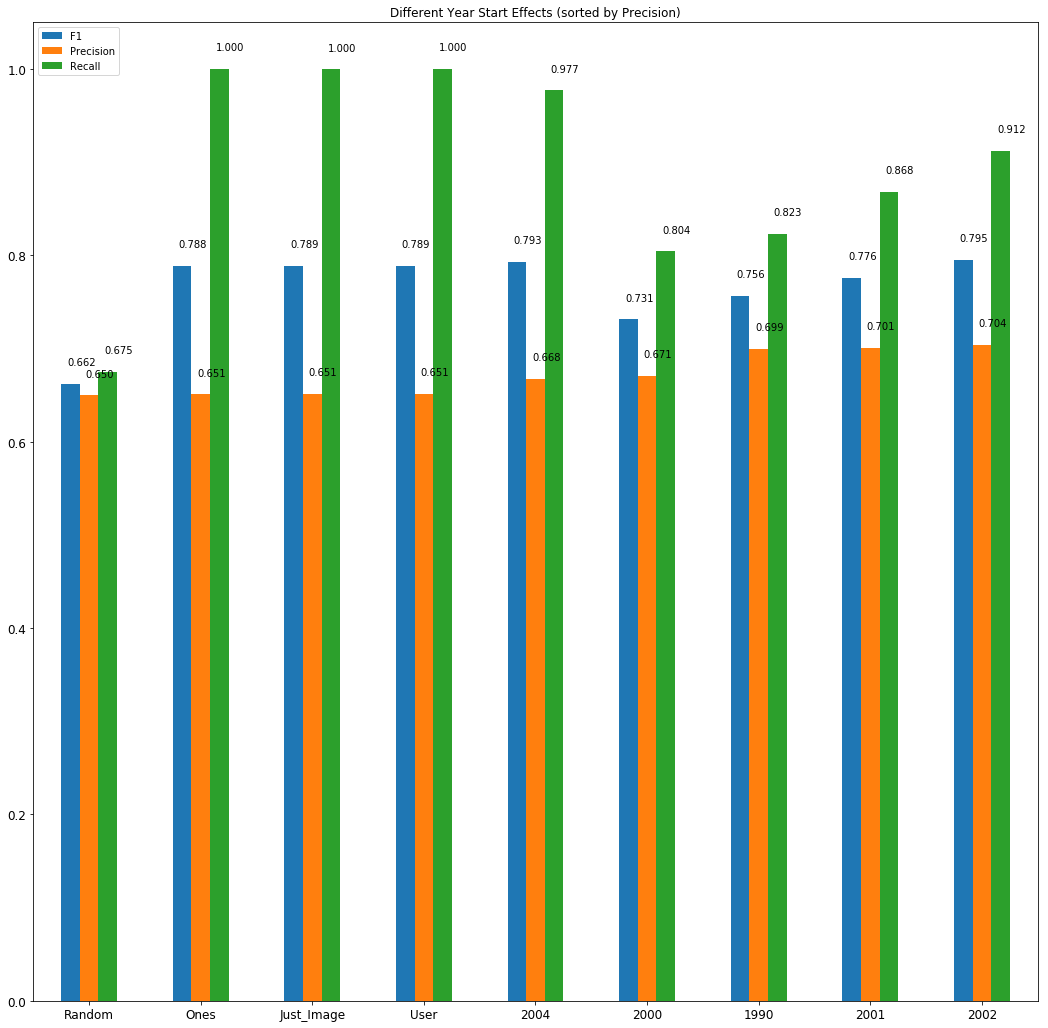

In [76]:
ax = overall_df_mean.sort_values('Precision').plot(kind='bar', title ="Different Year Start Effects (sorted by Precision)", figsize=(18, 18), legend=True, fontsize=12,)
plt.xticks(rotation=0)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper left')

x_offset = -0.03
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.3f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
plt.show()

**Precision@N to compare with CF Model**

In [62]:
Counter(all_runs_zero_prediction[6][:,0])

Counter({1: 10240, 0: 5496})

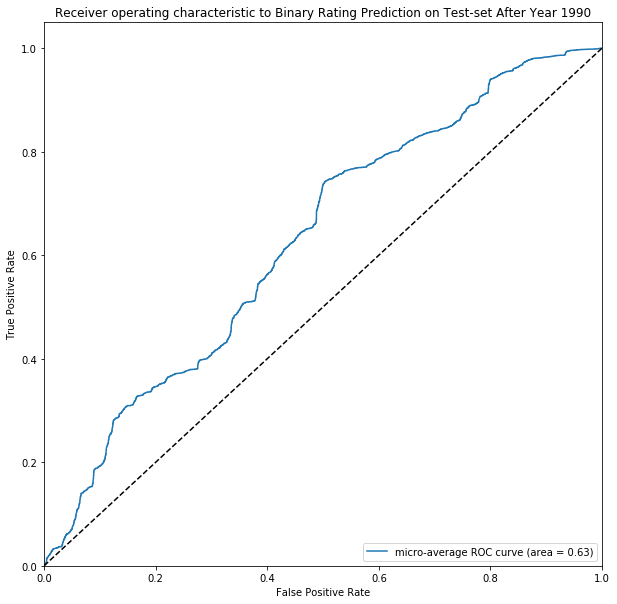

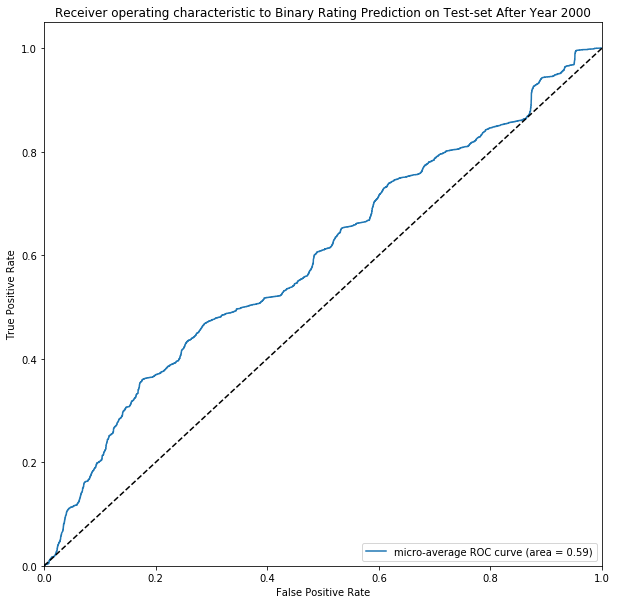

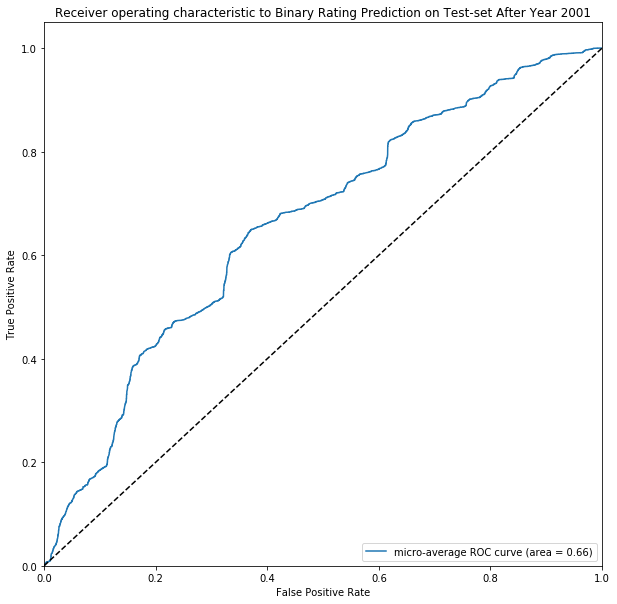

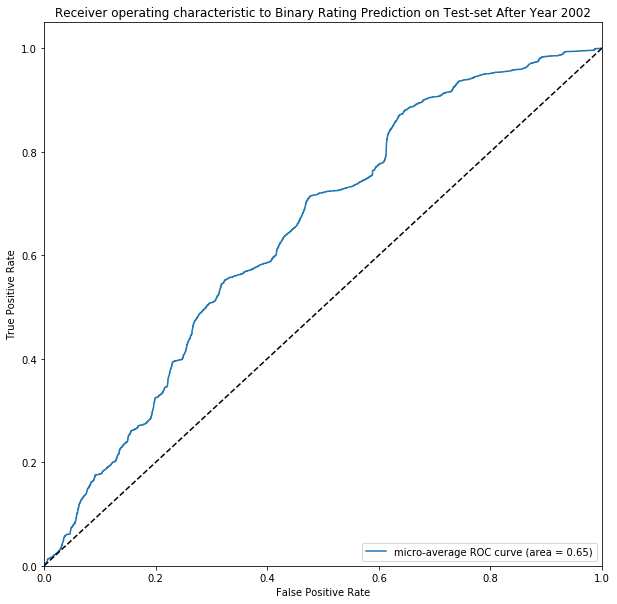

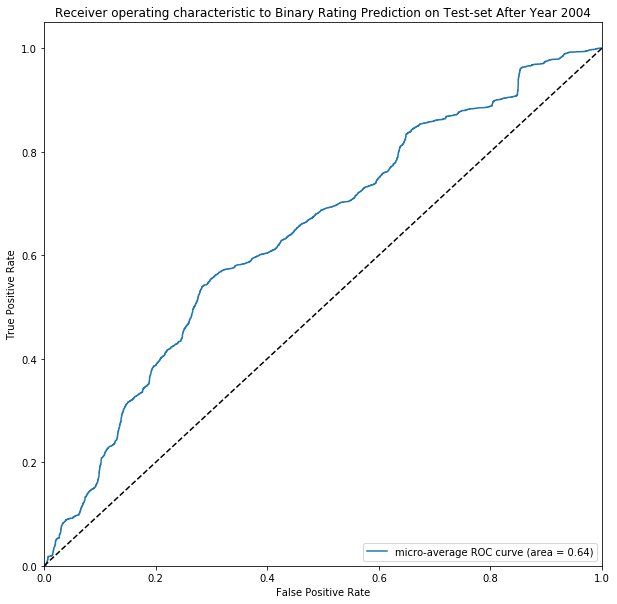

In [86]:
for _year_ in dict_year_run.keys():
    (validation_gt, validation_pr, validation_acc, \
     validation_loss, train_acc, train_loss, \
     test_gt, test_pr, test_acc, test_loss) = dict_year_run[_year_]
    #best = max([(ind,v) for ind, v in enumerate(validation_acc)], key=lambda x:x[1])
    #best = max([(ind,v) for ind, v in enumerate(validation_acc2)], key=lambda x:x[1])
    best = min([(ind,v) for ind, v in enumerate(validation_loss)], key=lambda x:x[1])
    val_batch_score = test_pr[best[0]] #validation_pr[best[0]]
    val_batch_gt = test_gt[best[0]] # validation_gt[best[0]]
    
    f1 = f1_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    prec = precision_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    recall = recall_score(test_gt[best[0]].ravel(),np.rint(test_pr[best[0]]).ravel())
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1):
        fpr[i], tpr[i], _ = roc_curve(val_batch_gt[:, i], val_batch_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(val_batch_gt.ravel(), val_batch_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #Plot ROC curve
    plt.figure(figsize=(10,10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    #for i in range(n_classes):
    # plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
    #                                    ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to Binary Rating Prediction on Test-set After Year '+str(_year_))
    plt.legend(loc="lower right")
    plt.show()

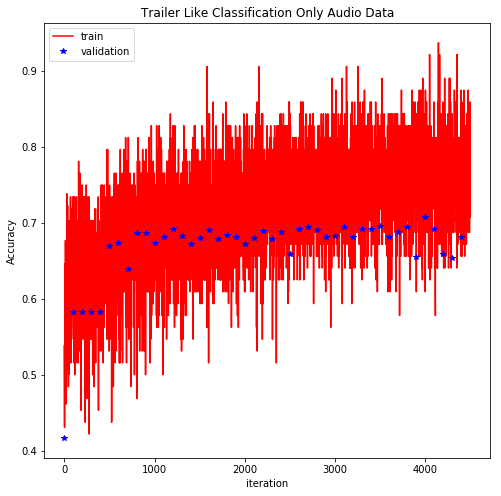

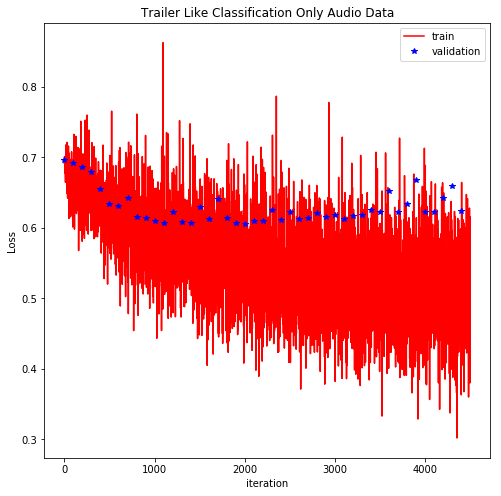

In [35]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (8,8))
plt.plot(t ,np.array(train_acc), 'r-', )
plt.plot(t[t % 100 == 0][:], np.array(validation_acc[:-1]), 'b*')
# plt.plot([0.4]*len(t), 'black')
plt.xlabel("iteration")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Trailer Like Classification Only Audio Data')
plt.show()
# Plot training and test loss
# t = np.arange(val_iteration)

plt.figure(figsize = (8,8))
plt.plot(t, np.array(train_loss), 'r-', t[t % 100 == 0][:], np.array(validation_loss[:-1]), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.title('Trailer Like Classification Only Audio Data')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [63]:
[(ind,v) for ind, v in enumerate(validation_acc) if v > .695]
[(ind,v) for ind, v in enumerate(validation_loss) if v < .61]

[(10, 0.6094836),
 (11, 0.60733956),
 (13, 0.6085527),
 (14, 0.607648),
 (19, 0.60640913),
 (20, 0.60560256)]

In [64]:
val_batch_score = test_pr[20]
val_batch_gt = test_gt[20]

In [65]:
from sklearn.metrics import roc_curve, auc

In [66]:
from collections import Counter
Counter(val_batch_gt[:,0])

Counter({1.0: 10292, 0.0: 5506})

In [67]:
from sklearn.metrics import f1_score, precision_score, recall_score
print(f1_score(val_batch_gt[:,0], np.rint(val_batch_score[:,0])))
print(precision_score(val_batch_gt[:,0], np.rint(val_batch_score[:,0])))
print(recall_score(val_batch_gt[:,0], np.rint(val_batch_score[:,0])))

0.7069495539988914
0.7343733640456497
0.6815001943256899


In [68]:
print(Counter(pd.DatetimeIndex(train.Timestamp).year))
print(Counter(pd.DatetimeIndex(val.Timestamp).year))

Counter({2005: 295260, 2001: 223202, 2006: 195527, 2004: 190109, 2003: 183133, 2002: 167020})
Counter({2005: 10411, 2006: 7807, 2001: 7623, 2003: 6122, 2002: 6082, 2004: 5822})


In [69]:
Counter(pd.DatetimeIndex(test.Timestamp).year)

Counter({2008: 11520, 2007: 4032, 2009: 246})

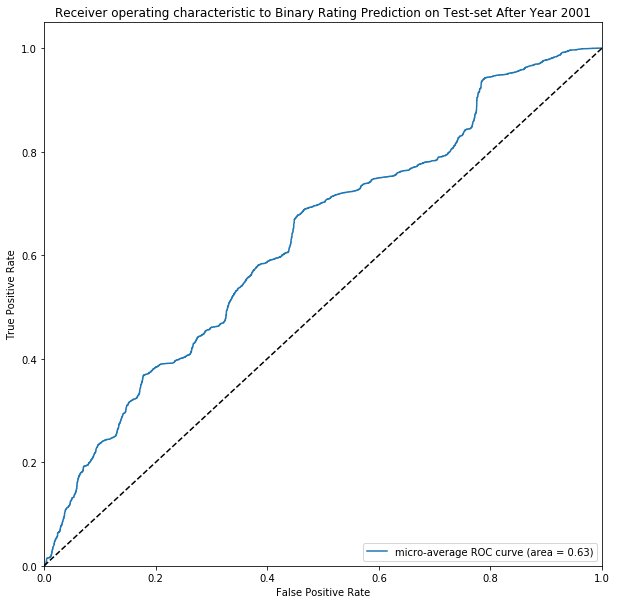

In [71]:
#Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
#for i in range(n_classes):
# plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
#                                    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to Binary Rating Prediction on Test-set After Year 2001')
plt.legend(loc="lower right")
plt.show()

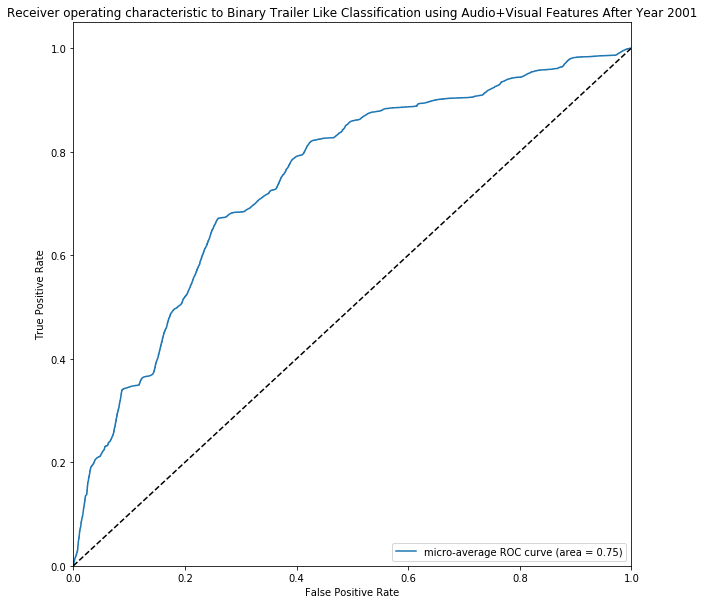

In [32]:
#Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
#for i in range(n_classes):
# plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
#                                    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to Binary Trailer Like Classification using Audio+Visual Features After Year 2001')
plt.legend(loc="lower right")
plt.show()

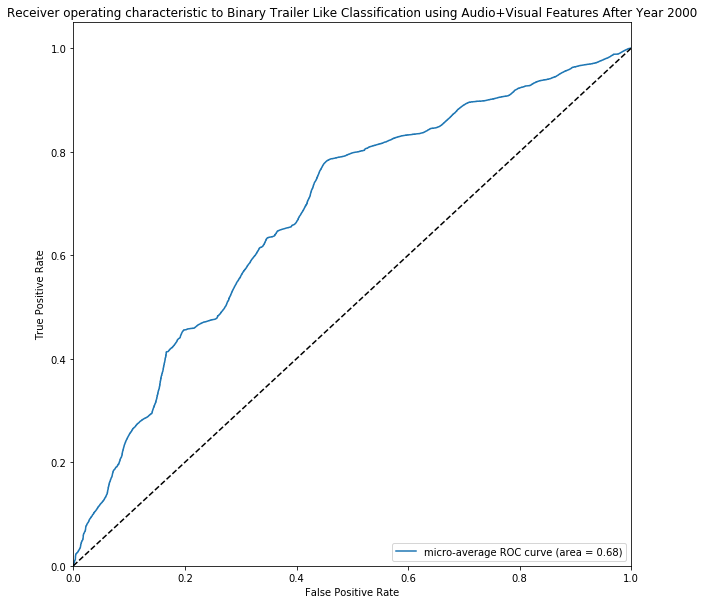

In [65]:
#Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
#for i in range(n_classes):
# plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
#                                    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to Binary Trailer Like Classification using Audio+Visual Features After Year 2000')
plt.legend(loc="lower right")
plt.show()

In [6]:
unique_movies_train = recmodel.data['training'].Movie.unique().tolist()
mov_to_rm = []
for id_ in recmodel.data['training'].Movie.unique().tolist() + recmodel.data['test'].Movie.unique().tolist():
    if not id_ in list(recmodel.visual_features.keys()):
        print(id_)
        continue
    if recmodel.visual_features[id_].shape[0] < 60:
        mov_to_rm.append(id_)
unique_movies_train = list(set(unique_movies_train) - set(mov_to_rm))

unique_movies_test = recmodel.data['test'].Movie.unique().tolist()
mov_to_rm = []
for id_ in recmodel.data['training'].Movie.unique().tolist()+recmodel.data['test'].Movie.unique().tolist():
    if not id_ in list(recmodel.visual_features.keys()):
        print(id_)
        continue
    if recmodel.visual_features[id_].shape[0] < 60:
        mov_to_rm.append(id_)
unique_movies_test = list(set(unique_movies_test) - set(mov_to_rm))

2558
2559
2561
2558
2559
2561


In [7]:
unique_movies = unique_movies_train + unique_movies_test
len(unique_movies)

7121

In [8]:
recmodel.user_item_network_training.CF_data.head(2)

,User,Movie,Rating,Timestamp
0,1,122,5.0,1996-08-02 11:24:06
1,1,185,5.0,1996-08-02 10:58:45


In [9]:
users_with_features = list(recmodel.user_item_network_training.CF_data.User.unique())
len(users_with_features)

62112

In [10]:
users_in_test = list(recmodel.data['test'].User.unique())
len(users_in_test)

8029

In [11]:
users_without_features = list(set(users_in_test) - set(users_with_features))
len(users_without_features)

5701

In [12]:
print(recmodel.data['test'].shape)
recmodel.data['test'][~recmodel.data['test'].User.isin(users_without_features)].shape

(103147, 4)


(43487, 4)

In [13]:
unique_movies_test = recmodel.data['test'][~recmodel.data['test'].User.isin(users_without_features)].Movie.unique().tolist()
mov_to_rm = []
for id_ in recmodel.data['training'].Movie.unique().tolist()+recmodel.data['test'][~recmodel.data['test'].User.isin(users_without_features)].Movie.unique().tolist():
    if not id_ in list(recmodel.visual_features.keys()):
        print(id_)
        continue
    if recmodel.visual_features[id_].shape[0] < 60:
        mov_to_rm.append(id_)
unique_movies_test = list(set(unique_movies_test) - set(mov_to_rm))

2558
2559
2561


In [15]:
unique_movies = unique_movies_train + unique_movies_test
len(unique_movies)

7112

In [16]:
import random

In [17]:
random.seed(123)
random_unique_movies = random.sample(unique_movies,1000)
unique_movies_train = list(set(unique_movies) - set(random_unique_movies))
unique_movies_test = random_unique_movies[:500]
unique_movies_validation = random_unique_movies[500:]
print('Training Sample:',len(unique_movies_train))
print('Validation Sample:',len(unique_movies_validation))
print('Test Sample:',len(unique_movies_test))

Training Sample: 6112
Validation Sample: 500
Test Sample: 500


In [23]:
df_audio = pd.DataFrame()
df_list = []
for sample in tqdm.tqdm(unique_movies_train, total=len(unique_movies_train), position=0):
    if sample in list(recmodel.audio_features.keys()):
        if recmodel.audio_features[sample].shape[0] >= 60:
            df_tmp = pd.DataFrame(recmodel.audio_features[sample][np.sort(random.sample(range(recmodel.audio_features[sample].shape[0]), 60)),:]) # recmodel.audio_features[sample])
            #df_tmp['movie_genre'] = [titles_df[titles_df.MovieID==sample].Output.values[0]] * 60
            df_tmp['movie_id'] = sample
            df_list.append(df_tmp)
        else:
            print(sample)
df_audio = pd.concat(df_list, axis=0)
del df_list
print(df_audio.shape)

df_audio_val = pd.DataFrame()
df_list = []
for sample in tqdm.tqdm(unique_movies_validation, total=len(unique_movies_validation), position=0):
    if sample in list(recmodel.audio_features.keys()):
        if recmodel.audio_features[sample].shape[0] >= 60:
            df_tmp = pd.DataFrame(recmodel.audio_features[sample][np.sort(random.sample(range(recmodel.audio_features[sample].shape[0]), 60)),:]) 
            #df_tmp['movie_genre'] = [titles_df[titles_df.MovieID==sample].Output.values[0]]*df_tmp.shape[0]
            df_tmp['movie_id'] = sample
            df_list.append(df_tmp)
        else:
            print(sample)
df_audio_val = pd.concat(df_list, axis=0)
del df_list
print(df_audio_val.shape)

df_audio_test = pd.DataFrame()
df_list = []
for sample in tqdm.tqdm(unique_movies_test, total=len(unique_movies_test), position=0):
    if sample in list(recmodel.audio_features.keys()):
        if recmodel.audio_features[sample].shape[0] >= 60:
            df_tmp = pd.DataFrame(recmodel.audio_features[sample][np.sort(random.sample(range(recmodel.audio_features[sample].shape[0]), 60)),:]) 
            #df_tmp['movie_genre'] = [titles_df[titles_df.MovieID==sample].Output.values[0]]*df_tmp.shape[0]
            df_tmp['movie_id'] = sample
            df_list.append(df_tmp)
        else:
            print(sample)
df_audio_test = pd.concat(df_list, axis=0)
del df_list
print(df_audio_test.shape)

 12%|█▏        | 705/6112 [00:00<00:03, 1392.88it/s]

750


 16%|█▋        | 1001/6112 [00:00<00:03, 1430.21it/s]

1330


 43%|████▎     | 2618/6112 [00:01<00:02, 1465.44it/s]

3635


 55%|█████▍    | 3341/6112 [00:02<00:01, 1411.06it/s]

4901
5056


 82%|████████▏ | 4985/6112 [00:03<00:00, 1282.68it/s]

7448
7482


 56%|█████▌    | 281/500 [00:00<00:00, 1379.87it/s]

(366120, 101)


 54%|█████▍    | 272/500 [00:00<00:00, 1335.81it/s]

(30000, 101)


100%|██████████| 500/500 [00:00<00:00, 1371.41it/s]


(30000, 101)


In [24]:
df_image = pd.DataFrame()
df_list = []
for sample in tqdm.tqdm(unique_movies_train, total=len(unique_movies_train), position=0):
    if sample in list(recmodel.visual_features.keys()):
        if recmodel.visual_features[sample].shape[0] >= 60:
            df_tmp = pd.DataFrame(recmodel.visual_features[sample][np.sort(random.sample(range(recmodel.visual_features[sample].shape[0]), 60)),:]) # recmodel.audio_features[sample])
            df_tmp['movie_id'] = sample
            df_list.append(df_tmp)
        else:
            print(sample)
df_image = pd.concat(df_list, axis=0)
del df_list
print(df_image.shape)

df_image_val = pd.DataFrame()
df_list = []
for sample in tqdm.tqdm(unique_movies_validation, total=len(unique_movies_validation), position=0):
    if sample in list(recmodel.visual_features.keys()):
        if recmodel.visual_features[sample].shape[0] >= 60:
            df_tmp = pd.DataFrame(recmodel.visual_features[sample][np.sort(random.sample(range(recmodel.visual_features[sample].shape[0]), 60)),:]) 
            df_tmp['movie_id'] = sample
            df_list.append(df_tmp)
        else:
            print(sample)
df_image_val = pd.concat(df_list, axis=0)
del df_list
print(df_image_val.shape)

df_image_test = pd.DataFrame()
df_list = []
for sample in tqdm.tqdm(unique_movies_test, total=len(unique_movies_test), position=0):
    if sample in list(recmodel.visual_features.keys()):
        if recmodel.visual_features[sample].shape[0] >= 60:
            df_tmp = pd.DataFrame(recmodel.visual_features[sample][np.sort(random.sample(range(recmodel.visual_features[sample].shape[0]), 60)),:]) 
            df_tmp['movie_id'] = sample
            df_list.append(df_tmp)
        else:
            print(sample)
df_image_test = pd.concat(df_list, axis=0)
del df_list
print(df_image_test.shape)

  3%|▎         | 14/500 [00:00<00:03, 139.65it/s]

(366540, 2049)


  3%|▎         | 16/500 [00:00<00:03, 159.30it/s]

(30000, 2049)


100%|██████████| 500/500 [00:02<00:00, 173.61it/s]


(30000, 2049)


In [26]:
df_image = df_image[df_image.movie_id.isin(df_audio.movie_id.unique().tolist())]

In [27]:
train_unique_movies_with_features = df_image.movie_id.unique().tolist()
print(len(train_unique_movies_with_features))

val_unique_movies_with_features = df_image_val.movie_id.unique().tolist()
print(len(val_unique_movies_with_features))

test_unique_movies_with_features = df_image_test.movie_id.unique().tolist()
print(len(test_unique_movies_with_features))

6102
500
500


## User Latent Factors

In [ ]:
ratings_df_training_filtered = ratings_df_training[ratings_df_training.Movie.isin(train_unique_movies_with_features)]
#ratings_df_test_filtered = ratings_df_training[ratings_df_training.Movie.isin(test_unique_movies_with_features)]

print(ratings_df_training_filtered.shape)

In [ ]:
len(pd.concat([ratings_df_training_filtered, ratin, ratings_df_test_filtered], axis=0).User.unique().tolist())

In [31]:
recmodel.user_item_network_training.CF_data.head()

,User,Movie,Rating,Timestamp
0,1,122,5.0,1996-08-02 11:24:06
1,1,185,5.0,1996-08-02 10:58:45
2,1,231,5.0,1996-08-02 10:56:32
3,1,292,5.0,1996-08-02 10:57:01
4,1,316,5.0,1996-08-02 10:56:32


In [39]:
data = pd.concat([recmodel.data['training'],recmodel.data['test']],axis=0).sample(frac=1, random_state=1321, axis=0).reset_index(drop=True)
data.shape

(7509267, 4)

In [43]:
data_train = data[~data.Movie.isin(val_unique_movies_with_features+test_unique_movies_with_features)]
data_val = data[data.Movie.isin(val_unique_movies_with_features)]
data_test = data[data.Movie.isin(test_unique_movies_with_features)]
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(6561219, 4)
(465288, 4)
(482760, 4)


In [50]:
data_test.head()

,User,Movie,Rating,Timestamp
6,31018,2011,3.5,2005-06-03 01:11:42
10,48990,3827,2.0,2004-07-10 04:55:38
19,40372,551,4.0,1999-12-13 06:50:35
59,39588,19,3.0,1996-11-04 16:56:10
61,26859,3082,3.0,2005-05-20 18:09:00


In [54]:
# data_train[data_train.User==26859]

In [55]:
print(data_train.User.nunique())
print(data_val.User.nunique())
print(data_test.User.nunique())
print()
print(data_train.Movie.nunique())
print(data_val.Movie.nunique())
print(data_test.Movie.nunique())

67655
59048
58949

6687
500
500


In [57]:
ratings_df_training_filtered = data_train[data_train.Rating.isin([1,1.5,2.0,4.5,5])].copy()#.sample(frac=1, random_state=1321)
ratings_df_val_filtered = data_val[data_val.Rating.isin([1,1.5,2.0,4.5,5])].copy()
ratings_df_test_filtered = data_test[data_test.Rating.isin([1,1.5,2.0,4.5,5])].copy()#.sample(frac=1, random_state=1321)
print(ratings_df_training_filtered.shape)
print(ratings_df_val_filtered.shape)
print(ratings_df_test_filtered.shape)

(2269258, 4)
(155718, 4)
(170449, 4)


In [59]:
def batch_generator(df, audio_features, visual_features, user_latent_traninig, batchsize=32):
    for batch in np.array_split(df, batchsize): 
        batch_x_audio, batch_x_image, batch_x_user, batch_y = [], [], [], [] 
        for ind, row in batch.iterrows():
            batch_x_audio.append(audio_features[row['Movie']])
            batch_x_image.append(visual_features[row['Movie']])
            batch_x_user.append(user_latent_traninig[row['User']])
            batch_y.append(int(row['Rating']>3.5))
    
        yield np.array(batch_x_audio)/100., np.array(batch_x_image), np.array(batch_x_user), np.array(batch_y)

def val_batch_generator(df, audio_features, visual_features, user_latent_traninig, batchsize=1):
    for batch in np.array_split(df, batchsize): 
        batch_x_audio, batch_x_image, batch_x_user, batch_y = [], [], [], [] 
        for ind, row in (batch.iterrows()):
            batch_x_audio.append(audio_features[row['Movie']])
            batch_x_image.append(visual_features[row['Movie']])
            batch_x_user.append(user_latent_traninig[row['User']])
            batch_y.append(int(row['Rating']>3.5))
    
        return np.array(batch_x_audio)/100., np.array(batch_x_image), np.array(batch_x_user), np.array(batch_y)

,User,Movie,Rating,Timestamp
10,48990,3827,2.0,2004-07-10 04:55:38
84,26661,1485,1.5,2005-05-19 18:23:08
192,18976,1206,5.0,1997-12-07 08:53:30
194,23673,2011,2.0,2000-03-09 19:13:42
196,46163,1496,5.0,1997-10-17 20:13:36


In [60]:
test_unique_movies_with_features[0]

551